<div style="text-align: center;">
  <h1>TA145 - Redes Neuronales y Aprendizaje Profundo</h1>
  <h2>Trabajo Práctico 1: Red de Hopfield</h2>
</div>

---
---

<div style="text-align: left;">
  <h3><b>Introducción</b></h3>
</div>

&ensp; En el presente trabajo, se analizan las redes de Hopfield como un modelo clásico de memoria asociativa, con el fin de comprender sus fundamentos teóricos y evaluar sus limitaciones en la práctica. Para ello, se estudia el modelado de la red y su base matemática, en particular la dinámica de actualización y la función de energía que aseguran la convergencia a estados estables, lo que es la base de su capacidad de recuperar información a partir de entradas incompletas. En función de esto, se llevan a cabo experimentos que abarcan distintos aspectos del modelo como lo son: la respuesta frente al ruido y el borrado de patrones, la aparición de estados espurios, la capacidad máxima de almacenamiento y la influencia de la correlación entre patrones, así como la robustez de la red frente a la eliminación de interconexiones.

---
---

<div style="text-align: left;">
  <h3><b>Base teórica</b></h3>
</div>

<div style="text-align: left;">
  <h4><b>Fundamentos del modelo de Hopfield</b></h4>
</div>

&ensp; Las redes de Hopfield son un tipo de red neuronal recurrente propuesta por John Hopfield en $1982$. Se caracterizan por ser modelos de memoria asociativa, es decir, pueden almacenar patrones y recuperarlos incluso cuando la entrada está incompleta o con ruido. Estas redes presentan una estructura totalmente conectada y simétrica, en la cual cada neurona se conecta con todas las demás, pero no consigo misma. Cada neurona $S_i$ puede tomar valores binarios ($+1$ o $-1$), lo que permite representar estados discretos de activación. 

&ensp; La Figura 1 muestra un esquema de esta arquitectura, donde cada nodo representa una neurona y las conexiones ilustran los pesos sinápticos que conforman la memoria distribuida de la red.

<center>

<figure> <img src="https://raw.githubusercontent.com/felipeperassi/Neural-Networks/fc64579a7856f6e17e2e243c9dc3ab1cd7518d0c/Hopfield-Networks/ReportImages/HopfieldNetworks.png" alt="Estructura de una red de Hopfield" width="300"> <figcaption><i>Figura 1.</i> Estructura de una red de Hopfield totalmente conectada.</figcaption> </figure>

</center>


&ensp;

<div style="text-align: left;">
  <h4><b>Regla de Hebb</b></h4>
</div>

&ensp; El aprendizaje de los patrones se logra mediante la regla de Hebb, que refuerza las conexiones entre neuronas que se activan de manera conjunta. La matriz de pesos sinápticos $w_{ij}$ se define como:

$$ w_{ij} = \frac{1}{N} ~ \sum_{\mu=0}^{P} \xi_i^\mu \cdot \xi_j^\mu, \quad w_{ii} = 0$$

donde $N$ el número total de neuronas, $P$ la cantidad de patrones a almacenar y $\xi_{i, ~ j}^\mu$ el valor del bit $i$ o $j$ dentro del patrón $\mu$.

&ensp;

<div style="text-align: left;">
  <h4><b>Dinámica y actualización de estados</b></h4>
</div>

&ensp; Una vez entrenada la red, el siguiente paso consiste en presentarle un patrón de entrada (completo, parcial o con ruido) y dejar que evolucione dinámicamente hasta converger a uno de los patrones previamente almacenados. Esta evolución se describe mediante la regla de actualización:

$$S_i = \text{sgn} \left( \sum_{j=1}^{N} w_{ij} S_j \right)$$

&ensp; La actualización de los estados puede realizarse de dos maneras:

- **Actualización sincrónica:** todas las neuronas actualizan su estado en paralelo en cada paso de tiempo. Esto es más simple de implementar y analizar, pero puede generar oscilaciones o estados cíclicos que no siempre corresponden a mínimos de energía.

- **Actualización asincrónica:** las neuronas se actualizan una por vez, de manera secuencial o aleatoria. En este caso, se garantiza que la función de energía decrece en cada actualización, lo que asegura la convergencia hacia un estado estable.

&ensp;

<div style="text-align: left;">
  <h4><b>Función de energía</b></h4>
</div>

&ensp; La energía es una función matemática que describe el estado global de la red. La dinámica de la red está diseñada para evolucionar hacia un estado estable, el cual corresponde a un mínimo de la función de energía $H$. Esta se define como:

$$H = -\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij} S_i S_j$$

La red actualiza sus estados de manera que la energía $H$ nunca aumenta, garantizando la convergencia hacia un mínimo. Dichos mínimos representan los patrones previamente almacenados, lo que permite corregir errores en entradas ruidosas e incluso reconstruir información faltante, funcionando como un sistema de memoria asociativa robusto.

<center>
<figure> <img src="https://raw.githubusercontent.com/felipeperassi/Neural-Networks/fc64579a7856f6e17e2e243c9dc3ab1cd7518d0c/Hopfield-Networks/ReportImages/EnergyFunction.png" alt="Función de energía en la red de Hopfield" width="600"> <figcaption><b>Figura 2.</b> Representación de la función de energía en una red de Hopfield.</figcaption> </figure>
</center>

&ensp;

<div style="text-align: left;">
  <h4><b>Estados espurios</b></h4>
</div>

&ensp; Además de los patrones almacenados correctamente mediante la regla de Hebb, pueden aparecer estados espurios. Estos corresponden a mínimos locales de la función de energía que no coinciden con ningún patrón de entrenamiento.

&ensp; Los principales tipos de estados espurios son:

- **Patrones invertidos:** el patrón almacenado y su inverso son igualmente estables.

$$ S_{\text{inv}} = -\boldsymbol{\xi} $$

- **Combinaciones de patrones:** la red puede converger hacia un estado que es una mezcla de un número impar de patrones.

$$S_{\text{mix}} = \text{sgn}\left(\sum_{\mu=1}^{2k+1} \boldsymbol{\xi}^{\mu}\right)$$

- **Spin glass:** son mínimos locales que no se parecen a ningún patrón almacenado.

&ensp;

<div style="text-align: left;">
  <h4><b>Capacidad de memoria</b></h4>
</div>

&ensp; Una cuestión fundamental en las redes de Hopfield es su capacidad de almacenamiento. Como cada patrón se codifica como un mínimo local de la función de energía, existe un límite máximo de patrones que la red puede guardar sin que aparezcan errores significativos en la recuperación.  

&ensp; La causa de estas limitaciones es la interferencia de los demás patrones almacenados durante el proceso de actualización, concepto conocido como *crosstalk*. Para la neurona $i$ en el patrón $\nu$, este término se expresa como:  

$$ C_i^\nu = -\xi_i^\nu \,\frac{1}{N} \sum_{j} \sum_{\mu \neq \nu} \xi_i^\mu \xi_j^\mu \xi_j^\nu $$

> Si $C_i^\nu$ es pequeño o negativo, no altera el valor correcto de la neurona. En cambio, si $C_i^\nu > 1$, la señal de la neurona se invierte y el patrón $\nu$ se vuelve inestable.  

&ensp; Considerando patrones idénticamente distribuidos e independientes, los valores de $C_i^\nu$ pueden aproximarse mediante el teorema central del límite a una variable gaussiana de media cero y varianza $\sigma^2 = \frac{p}{N}$. Así, según lo mencionado con antelación, la probabilidad de error corresponde a:  

$$ P_{\text{error}} = \mathbb{P}(C_i^\nu > 1) \Longrightarrow \alpha = \frac{p_{\text{max}}}{N}$$

donde $\alpha$ es la carga crítica de la red y se obtiene evaluando la probabilidad sobre la distribución gaussiana y despejando para $\frac{p}{N}$. Esta indica cuántos patrones por neurona pueden almacenarse sin superar un nivel de error dado y da lugar a la tabla que se visualiza a continuación.

<center>

| $P_{\text{error}}$ | $\frac{p_{\text{max}}}{N}$ |
|--------|--------|
| 0,001  | 0,105  |
| 0,0036 | 0,138  |
| 0,01   | 0,185  |
| 0,05   | 0,37   |
| 0,1    | 0,61   |

</center>

<center>
<b>Tabla 1.</b> Valores de la carga crítica en función de la probabilidad de error.
</center>

&ensp;

<div style="text-align: left;">
  <h4><b>Patrones correlacionados y limitaciones prácticas</b></h4>
</div>

&ensp; El análisis anterior se basa en el supuesto de que los patrones almacenados son independientes y no presentan correlaciones. No obstante, en aplicaciones reales esta condición rara vez se cumple, ya que, los datos suelen compartir similitudes estructurales.

&ensp; Bajo estas circunstancias, los vectores de memoria dejan de ser ortogonales y la matriz de pesos tiene una mayor superposición entre patrones. Como consecuencia, el término de *crosstalk* se intensifica, dificultando la diferenciación correcta entre estados almacenados. Esto reduce la capacidad efectiva de la red y aumenta la probabilidad de errores de recuperación, así como la aparición de estados espurios.

---
---

<div style="text-align: left;">
  <h3><b>Desarrollo</b></h3>
</div>

<div style="text-align: left;">
  <h4><b>Ejercicio 1</b></h4>
</div>

**Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.**

&ensp; En primer lugar, se importan las librerías necesarias para el desarrollo del código implementado. Además, se definen las rutas relativas hacia las carpetas que contienen las imágenes de tamaños $50 \times 50$ y $60 \times 45$, que serán utilizadas a lo largo del trabajo.

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from PIL import Image
import os

path_50x50 = 'Images/50x50/'
path_60x45 = 'Images/60x45/'

&ensp; Luego, se realizan funciones para cargar y visualizar imágenes. La función $\texttt{load\_images}$ permite leer todas las imágenes de una carpeta y convertirlas en una lista de *arrays*, con la opción de redimensionarlas si se desea. Por otro lado, $\texttt{plot\_images}$ facilita la visualización de una lista de imágenes en una sola fila, mostrando cada imagen en escala de grises y sin ejes.

In [266]:
def load_images(folder_path, resize=None) -> list[np.ndarray]:
    """
    Loads BMP images from a specified folder and returns them as a list of numpy arrays.
    """
    if folder_path is None or not os.path.isdir(folder_path):
        raise ValueError("Invalid folder path.")
    
    images = []
    for image_name in os.listdir(folder_path):
        if image_name.lower().endswith('.bmp'):
            image_path = os.path.join(folder_path, image_name)
            with Image.open(image_path) as img:
                if resize:
                    img = img.resize(resize)
                images.append(np.array(img))
    
    return images

def plot_images(images) -> None:
    """
    Plots a list of images in a single row.
    """
    if (len(images) == 0):
        raise ValueError("No images to display.")

    elif (len(images) == 1):
        plt.figure(figsize=(3.5, 5))
        plt.imshow(images[0], cmap='gray')
        plt.axis('off')

    else:
        size = (10, 5) if len(images) <= 5 else (20, 10)
        fig, axes = plt.subplots(1, len(images), figsize=size)
        for i, ax in enumerate(axes):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

&ensp; A continuación, se cargan las imágenes desde las rutas definidas y se visualizan para verificar su correcto procesamiento. Estas funciones permiten preparar y revisar los datos de entrada antes de entrenar y evaluar la Red de Hopfield, asegurando que las imágenes se encuentren en el formato y tamaño esperado.

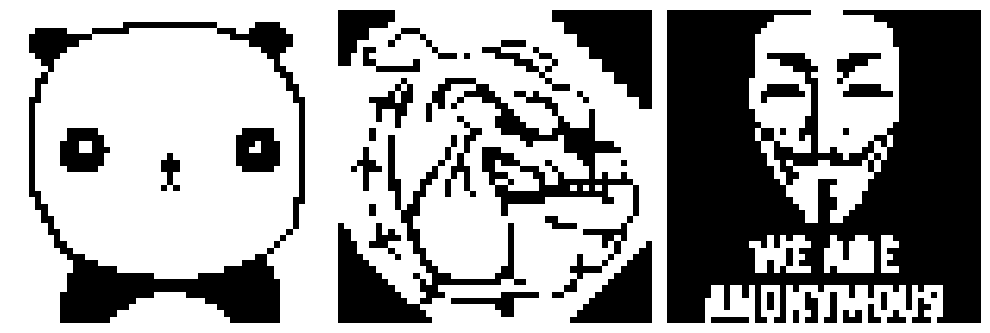

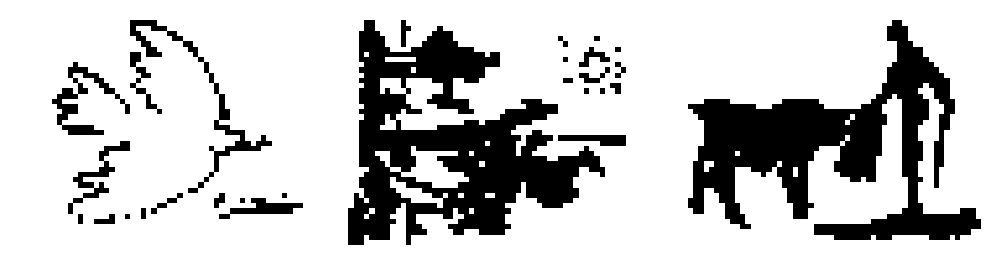

In [267]:
images_50x50 = load_images(path_50x50)
plot_images(images_50x50)

images_60x45 = load_images(path_60x45)
plot_images(images_60x45)

&ensp; Una vez cargadas las imágenes, se implementa la clase $\texttt{HopfieldNetwork}$, que permite entrenar patrones binarios y recuperar imágenes a partir de entradas parciales o ruidosas. La clase incluye los siguientes métodos principales:

- $\texttt{\_\_init\_\_}$: Inicializa los atributos de la red, incluyendo los pesos, la cantidad de neuronas y el número de iteraciones realizadas durante la predicción.

- $\texttt{\_preprocess\_patterns(patterns)}$: Convierte los patrones de entrada de valores binarios: $0$ y $1$, a valores centrados alrededor del cero: $-1$ y $1$. Esto es requerido por la red de Hopfield, ya que, esta funciona de manera más eficiente con valores simétricos.  
  
\begin{align*}
  S_i = 2 \cdot \text{pattern}_i - 1 \Longrightarrow 
  \begin{cases} 
  -1 & \text{si } \text{pattern}_i = 0  \\
  1 & \text{si } \text{pattern}_i = 1
  \end{cases}
\end{align*}

- $\texttt{train(patterns)}$: Entrena la red utilizando el aprendizaje Hebbiano propio de la red de Hopfield. En primer lugar, convierte los patrones a $-1$ y $1$ con el método $\texttt{\_preprocess\_patterns}$, luego calcula la matriz de pesos según:  

  $$ w_{ij} = \frac{1}{N} ~ \sum_{\mu=0}^{P} \xi_i^\mu \cdot \xi_j^\mu, \quad w_{ii} = 0$$

- $\texttt{predict(test\_pattern)}$: Dado un patrón de entrada (completo, parcial o con ruido), la red aplica la dinámica de actualización hasta converger a un estado estable:

  \begin{align*}
    S_i^{\text{current}} = \text{sgn}\left(\sum_{j = 0}^N w_{ij} \cdot S_j^{\text{previous}}\right)
  \end{align*}
  - Con actualización sincrónica (`synchronic=True`), todas las neuronas se actualizan al mismo tiempo.
  - Con actualización asincrónica (`synchronic=False`), se actualiza una neurona por vez en orden aleatorio hasta que ya no haya cambios.

- $\texttt{predict\_multiple(test\_patterns, size)}$: Aplica el método $\texttt{predict}$ a múltiples patrones de entrada (listas de *arrays*) y devuelve los resultados con la forma original de cada imagen.

In [268]:
class HopfieldNetwork:

    def __init__(self):
        self.weights = None
        self.n_neurons = None
        self.iterations = 0

    def _preprocess_patterns(self, patterns) -> np.ndarray:
        """
        Preprocesses the input patterns for the Hopfield network.
        """
        images_hopfield = [np.where(2 * patterns[i] - 1 >= 0, 1, -1) for i in range(len(patterns))]
        return np.array(images_hopfield)

    def train(self, patterns, remove_rate=None) -> None:
        """
        Trains the Hopfield network on binary patterns (0/1),
        converts them to -1/+1, updates weights with Hebbian learning
        and optionally removes a fraction of interconnections in weights.
        """
        if patterns is None:
            raise ValueError("Input patterns cannot be None")

        if not isinstance(patterns, list):
            raise ValueError("Input patterns must be a list")

        hopfield_pattern = self._preprocess_patterns(patterns)
        n_patterns = hopfield_pattern.shape[0]
        
        neurons = hopfield_pattern.reshape(n_patterns, -1)
        self.n_neurons = neurons.shape[1]

        self.weights = (neurons.T @ neurons) / n_patterns

        if remove_rate is not None and 0 <= remove_rate <= 1:
            mask = np.random.rand(*self.weights.shape) > remove_rate
            self.weights *= mask
        
        np.fill_diagonal(self.weights, 0)

    def predict(self, test_pattern, synchronic) -> np.ndarray:
        """
        Predicts the output of the Hopfield network for a single input pattern.
        If synchronic is True, updates all neurons at once; otherwise, updates asynchronously.
        """
        if test_pattern is None:
            raise ValueError("Input pattern cannot be None")

        if not isinstance(test_pattern, (np.ndarray, list)):
            raise ValueError("Input pattern must be a numpy array or a list")
        
        hopfield_test_pattern = self._preprocess_patterns(test_pattern)
        current_neurons = hopfield_test_pattern.reshape(-1)

        if synchronic:
            current_neurons = np.where(self.weights @ current_neurons.T >= 0, 1, -1)
                
        else:
            new_neurons = np.zeros_like(current_neurons)
            self.iterations = 0

            while True:
                changes = 0
                for i in np.random.permutation(self.n_neurons):
                    new_neurons = current_neurons
                    new_neurons[i] = np.where(self.weights[i] @ new_neurons.T >= 0, 1, -1)
                    if new_neurons[i] != current_neurons[i]:
                        current_neurons = new_neurons
                        changes += 1
                    
                if changes == 0:
                    break

                self.iterations += 1

        return current_neurons

    def predict_multiple(self, test_patterns, size, synchronic=False) -> list[np.ndarray]:
        """
        Predicts the output of the Hopfield network for multiple input patterns of a given size.
        """
        if test_patterns is None:
            raise ValueError("Input patterns cannot be None")

        if not isinstance(test_patterns, list):
            raise ValueError("Input patterns must be a list")

        predictions = []
        for pattern in test_patterns:
            prediction = self.predict(pattern, synchronic)
            predictions.append(prediction.reshape(size))
        
        return predictions

&ensp; La implementación de est clase resulta útil porque organiza de manera modular todas las funciones necesarias para entrenar y probar una red de Hopfield. Al encapsular el preprocesamiento, el cálculo de pesos y las reglas de actualización en métodos independientes, el código se vuelve más legible, fácil de mantener y reutilizable.

&ensp;

**(A). Verifique si la red aprendió las imágenes enseñadas.**

&ensp; En una primera instancia, se definió la función $\texttt{calculate\_accuracy}$, que compara el porcentaje de coincidencia píxel por píxel de la imagen original con la imagen predicha por la red. De esta forma, el resultado obtenido es una métrica de *accuracy* que indica qué tan fielmente se recuerda cada imagen.

In [269]:
def calculate_accuracy(original, predicted) -> list[float]:
    """
    Calculates the accuracy of the Hopfield network's predictions.
    """
    if original is None or predicted is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(original, list) or not isinstance(predicted, list):
        raise ValueError("Input patterns must be lists")

    n_original = len(original)
    if n_original != len(predicted):
        raise ValueError("Input patterns must have the same length")

    original = [np.where(2 * original[i] - 1 >= 0, 1, -1) for i in range(n_original)] # Convert to -1 & 1

    accuracy = []
    for i in range(n_original):
        if original[i].shape != predicted[i].shape:
            raise ValueError("All patterns must have the same shape")

        accuracy.append(np.mean(original[i] == predicted[i]))

    return accuracy


&ensp; Posteriormente, se iniciaron dos redes de Hopfield entrenadas con las imágenes de distintas dimensiones, así se utilizó el método $\texttt{predict\_multiple}$ para intentar recuperarlas. Los resultados se visualizan mediante $\texttt{plot\_images}$, lo que permite observar de manera directa si las imágenes originales fueron correctamente memorizadas.

&ensp; Por último, se utilizó la función $\texttt{calculate\_accuracy}$ sobre cada conjunto de imágenes. Esto permite obtener un valor numérico de exactitud para cada caso, mostrado en formato porcentual junto al índice de la imagen. Así, no solo se cuenta con una verificación visual, sino también con una medida cuantitativa que confirma si la red efectivamente aprendió los patrones presentados.

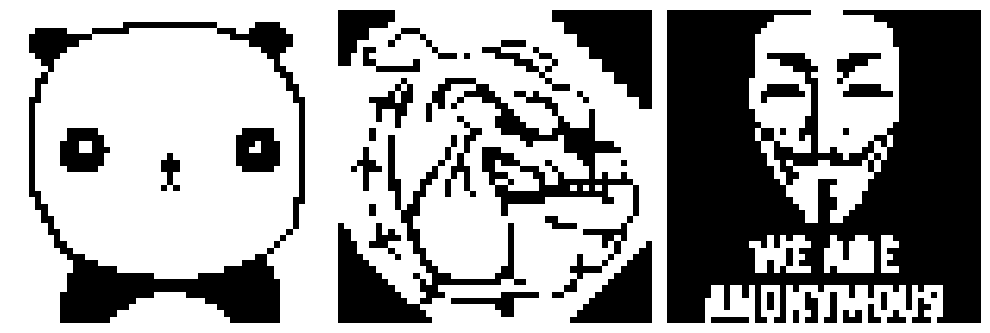

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [270]:
HN_50x50 = HopfieldNetwork()
HN_50x50.train(images_50x50)
predicted_50x50 = HN_50x50.predict_multiple(images_50x50, (50, 50))

plot_images(predicted_50x50)

accuracies_50x50 = calculate_accuracy(images_50x50, predicted_50x50)
for i, acc in enumerate(accuracies_50x50):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

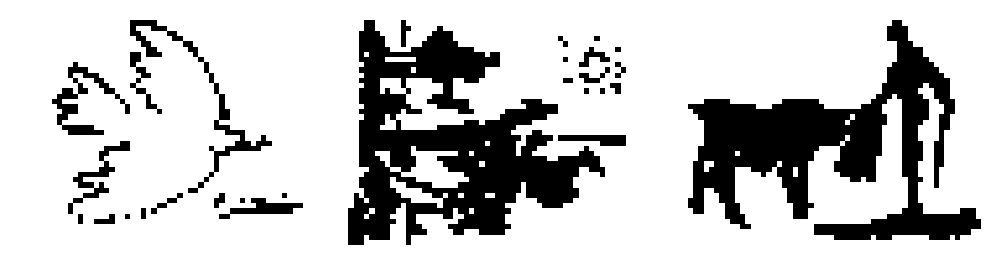

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [271]:
HN_60x45 = HopfieldNetwork()
HN_60x45.train(images_60x45)
predicted_60x45 = HN_60x45.predict_multiple(images_60x45, (45, 60)) #60x45 means 45 rows & 60 columns

plot_images(predicted_60x45)

accuracies_60x45 = calculate_accuracy(images_60x45, predicted_60x45)
for i, acc in enumerate(accuracies_60x45):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; Como resultado del entrenamiento y la evaluación, se observa que la red logra recuperar todas las imágenes enseñadas de manera perfecta, alcanzando en cada caso un $ 100 \%$ de *accuracy*. Esto confirma que los patrones fueron almacenados de forma estable y que, al presentarlos nuevamente, se reproducen sin errores.

&ensp;

**(B). Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.**

&ensp; A fin de evaluar la red frente a perturbaciones en los datos de entrada, se implementaron dos funciones. La función $\texttt{generate\_noise}$ agrega ruido aleatorio a las imágenes, a partir de una fracción de píxeles según el nivel especificado. Por su parte, $\texttt{erase\_images}$ borra un bloque rectangulo de píxeles en cada imagen, generando imágenes parciales que permiten analizar el desempeño de la red.

In [272]:
def generate_noise(images, noise_level) -> list[np.ndarray]:
    """
    Generates random noise to add to the images.
    """
    noisy_images = []
    for img in images:
        noise = np.random.binomial(1, 1 - noise_level, img.shape)
        noisy_images.append(img * noise)
    
    return noisy_images

def erase_images(images, erase_percentage) -> list[np.ndarray]:
    """
    Erases a rectangular block of pixels from each image according to the given erase percentage.
    The rectangle area corresponde al porcentaje definido.
    """
    erased_images = []
    
    for img in images:
        m, n = img.shape
        area_to_erase = int(erase_percentage * m * n)
        
        rect_height = int(np.sqrt(area_to_erase * m / n))
        rect_width = int(area_to_erase / rect_height) if rect_height > 0 else 0

        rect_height = min(rect_height, m)
        rect_width = min(rect_width, n)

        max_x = m - rect_height
        max_y = n - rect_width
        start_x = np.random.randint(0, max_x + 1)
        start_y = np.random.randint(0, max_y + 1)

        img = img.astype(float)
        img[start_x:start_x + rect_height, start_y:start_y + rect_width] = 0.5

        erased_images.append(img)
    
    return erased_images

&ensp; En base a estas dos funciones, se define $\texttt{plot\_accuracy\_variation}$ que permite evaluar cómo cambia la precisión del modelo frente a diferentes niveles de ruido. Así, se generan imágenes alteradas a partir de las originales y se obtienen las predicciones del modelo, para luego calcular la *accuracy* alcanzada en cada caso y graficarla.

In [273]:
def plot_accuracy_variation(model, original, noise_bool, noise_levels, size) -> None:
    """
    Plots the accuracy variation of the model for different noise/erasure/spurious levels.
    """
    accuracies = []
    for noise in noise_levels:
        if noise_bool:
            noisy_images = generate_noise(original, noise)
        else:
            noisy_images = erase_images(original, noise)
        
        predictions = model.predict_multiple(noisy_images, size)
        accuracy = calculate_accuracy(original, predictions)
        accuracies.append(accuracy)

    legends = [f'Imagen {i+1}' for i in range(len(original))]
    plt.plot(noise_levels, accuracies, label=legends)
    if noise_bool:
        plt.title('Model Accuracy Variation with Noise Level')
        plt.xlabel('Noise Level')
    else:
        plt.title('Model Accuracy Variation with Erasure Level')
        plt.xlabel('Erasure Level')
        
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

&ensp; Con el objetivo de evaluar la capacidad de la red para reconstruir patrones ruidosos, se generan imágenes con un nivel de ruido del $45%$, las cuales son recuperadas por la red de Hopfield previamente entrenada, como se muestra a continuación.

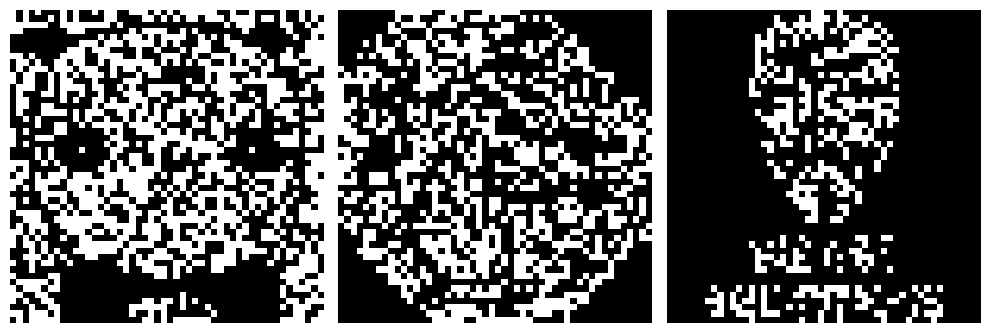

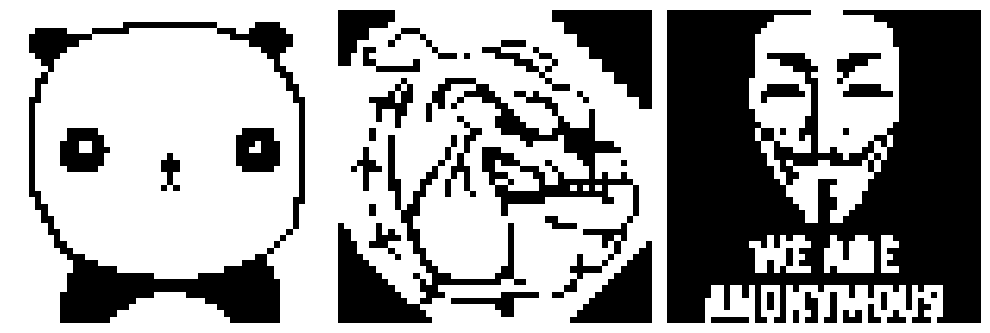

In [274]:
images_50x50_noisy = generate_noise(images_50x50, noise_level=0.45)
plot_images(images_50x50_noisy)

predicted_50x50_noisy = HN_50x50.predict_multiple(images_50x50_noisy, (50, 50))
plot_images(predicted_50x50_noisy)

&ensp; Tras comprobar que la red es capaz de recuperar imágenes con ruido moderado, se busca determinar hasta qué nivel de perturbación logra mantener un buen desempeño. Para ello, se evalúa el modelo prediciendo las imágenes originales mientras se incrementa progresivamente el nivel de ruido. De esta manera, se obtienen las curvas de *accuracy* para cada imagen, lo que permite observar cómo varía la capacidad de recuperación de la red en función del ruido introducido.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

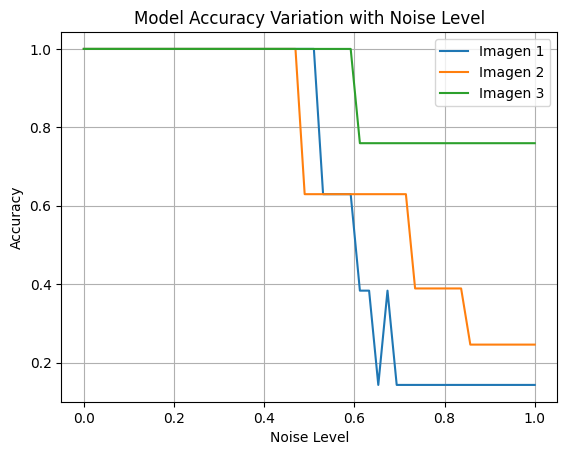

In [275]:
accuracies_50x50_noisy = calculate_accuracy(images_50x50, predicted_50x50_noisy)
for i, acc in enumerate(accuracies_50x50_noisy):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

noise_levels = np.linspace(0, 1, 50)
plot_accuracy_variation(HN_50x50, images_50x50, noise_bool=True, noise_levels=noise_levels, size=(50, 50))

&ensp; Analizando los resultados obtenidos, se puede decir que el modelo mantiene una accuracy del $100 \%$ mientras el nivel de ruido es bajo, pero a partir de un umbral cercano a aproximadamente $0.5$ cae bruscamente. Además, se observa que algunas imágenes conservan un rendimiento mayor que otras, lo que indica que la red es sensible al ruido de manera distinta según el contenido de cada patrón, ya que ciertas características, como la presencia de amplias zonas en negro en el caso de la imagen $3$, son menos sensibles al ruido.

&ensp; Siguiendo esta misma línea de análisis, se realiza el procedimiento análogo con las imágenes de $60 \times 45$. En este caso, la red también logra recuperar correctamente los patrones con un nivel de ruido del $45\%$, y al incrementar progresivamente la perturbación se obtienen las curvas de *accuracy*, lo que permite comparar su desempeño frente a distintos grados de ruido.

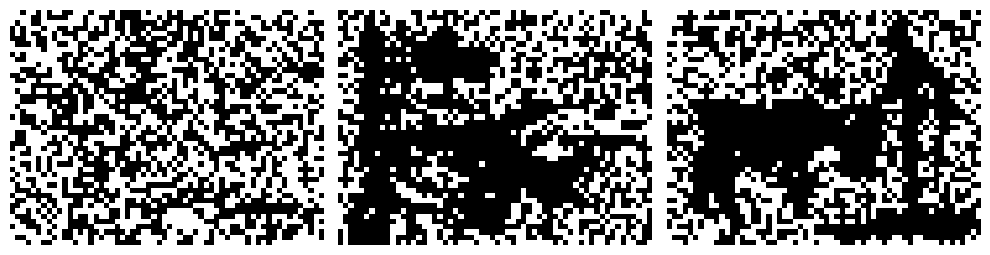

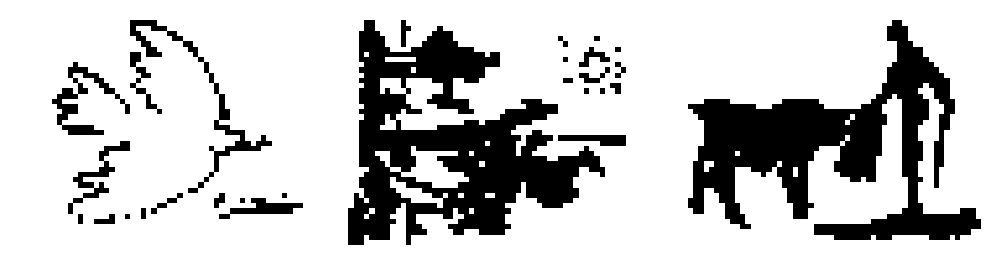

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

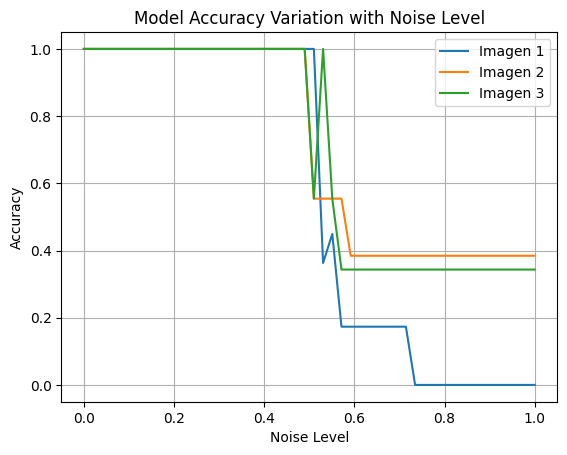

In [276]:
images_60x45_noisy = generate_noise(images_60x45, noise_level=0.45)
plot_images(images_60x45_noisy)

predicted_60x45_noisy = HN_60x45.predict_multiple(images_60x45_noisy, (45, 60))
plot_images(predicted_60x45_noisy)

accuracies_60x45_noisy = calculate_accuracy(images_60x45, predicted_60x45_noisy)
for i, acc in enumerate(accuracies_60x45_noisy):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_60x45, images_60x45, noise_bool=True, noise_levels=noise_levels, size=(45, 60))

&ensp; Al igual que en el caso de las imágenes de $50 \times 50$, el modelo mantiene una accuracy del $100\%$ con niveles bajos de ruido, pero a partir de un umbral cercano a $0.5$ la precisión desciende. Se observa además que las imágenes $2$ y $3$ logran estabilizarse en torno al $35\%-40\%$, mientras que la imagen 1 se degrada más rápidamente, lo que confirma que la sensibilidad al ruido depende de las características propias de cada patrón.

&ensp; A continuación, se realiza exactamente lo mismo utilizando la función $\texttt{erase\_images}$ que borra un bloque rectangulo en cada imagen. Esto permite evaluar el comportamiento de la red frente a eliminaciones localizadas, comparando cómo varía la *accuracy* en función del porcentaje de área eliminada.

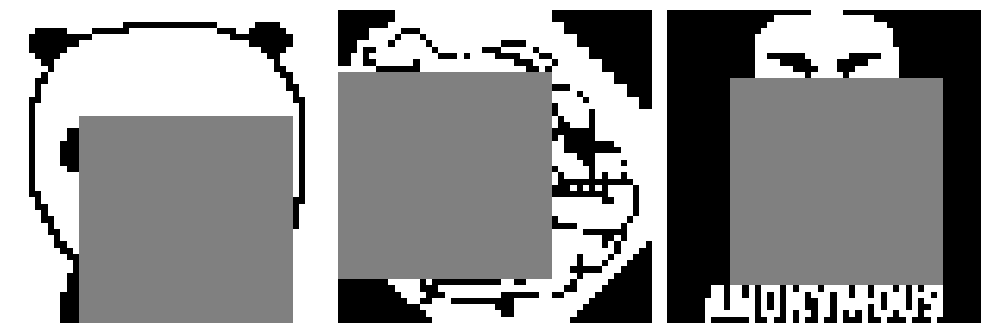

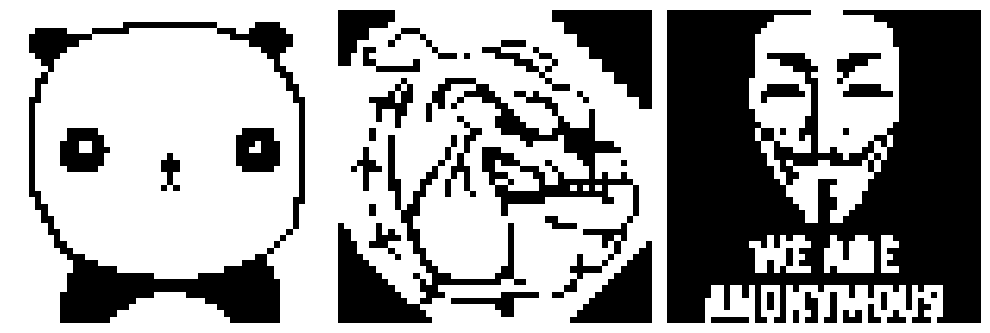

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

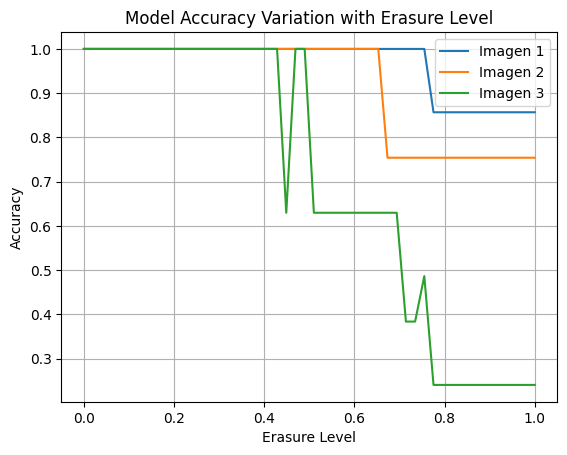

In [277]:
images_50x50_erased = erase_images(images_50x50, erase_percentage=0.45)
plot_images(images_50x50_erased)

predicted_50x50_erased = HN_50x50.predict_multiple(images_50x50_erased, (50, 50))
plot_images(predicted_50x50_erased)

accuracies_50x50_erased = calculate_accuracy(images_50x50, predicted_50x50_erased)
for i, acc in enumerate(accuracies_50x50_erased):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_50x50, images_50x50, noise_bool=False, noise_levels=noise_levels, size=(50, 50))

&ensp; En el caso de las imágenes de $50 \times 50$, el modelo mantiene una *accuracy* elevada para niveles bajos de eliminación, pero a medida que aumenta el porcentaje borrado la precisión disminuye de forma desigual entre las imágenes. Esto se debe a que la posición del bloque es aleatoria: cuando tapa regiones críticas del patrón la red pierde capacidad de recuperación, mientras que si cubre zonas menos relevantes la *accuracy* es mayor. Por esta misma aleatoriedad, las curvas presentan subidas y bajadas en lugar de un descenso uniforme.

&ensp; Ahora, se examina el borrado parcial de los patrones para la red de Hopfield entrenada con los tamaños de $60 \times 45$.

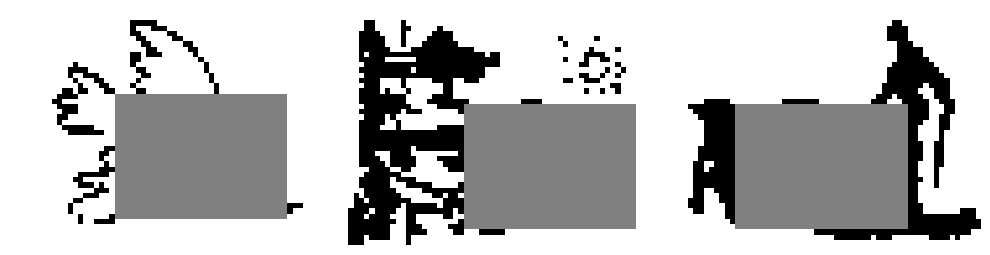

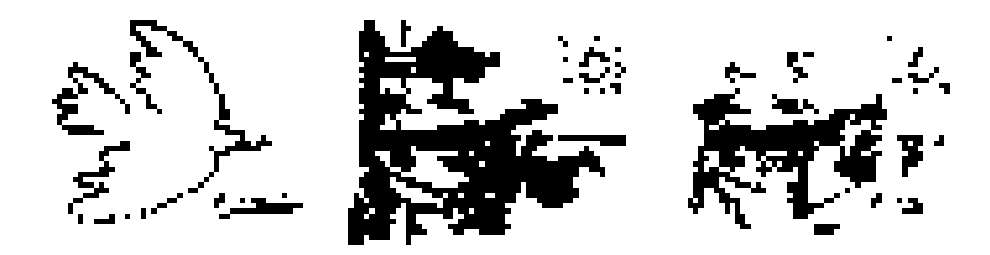

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

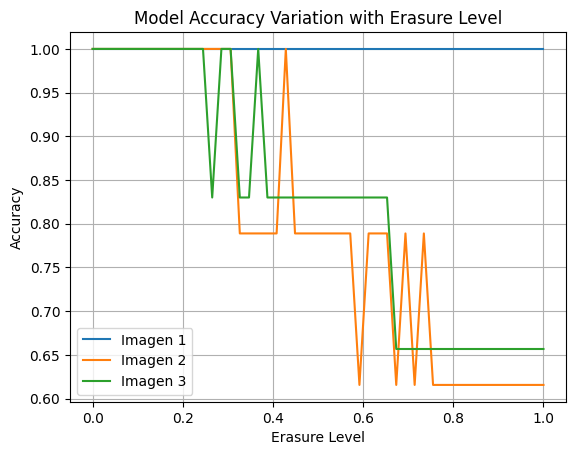

In [278]:
images_60x45_erased = erase_images(images_60x45, erase_percentage=0.3)
plot_images(images_60x45_erased)

predicted_60x45_erased = HN_60x45.predict_multiple(images_60x45_erased, (45, 60))
plot_images(predicted_60x45_erased)

accuracies_60x45_erased = calculate_accuracy(images_60x45, predicted_60x45_erased)
for i, acc in enumerate(accuracies_60x45_erased):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

plot_accuracy_variation(HN_60x45, images_60x45, noise_bool=False, noise_levels=noise_levels, size=(45, 60))

&ensp; Con las eliminaciones rectangulares, la Imagen $1$ se recupera siempre, incluso cuando el `erasure_level` alcanza $1$ y no se ve absolutamente nada. Este fenómeno se repite también en los patrones $2$ y $3$, donde la red predice igualmente la Imagen $1$. Esto indica que dicho patrón presenta una mayor redundancia y es más dominante en la memoria de la red, lo que facilita su reconstrucción. En cambio, las imágenes $2$ y $3$ sí ven degradada su *accuracy* conforme aumenta el nivel de borrado. Se puede entender que las subidas y bajadas de las curvas responden a la posición aleatoria del bloque rectangular, es decir: si cubre zonas críticas del patrón la precisión cae; mientras que, al tapar regiones menos relevantes, la red mantiene mejores predicciones.

&ensp;

**(C). Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones.** 

&ensp; Tal como se explicó en el apartado teórico, un estado espurio corresponde a un mínimo local de la red que no coincide con ninguno de los patrones de entrenamiento. Para verificar su existencia, se puede presentar a la red algunos de estos estados espurios conocidos y analizar si son reconstruidos correctamente. Esto es precisamente lo que se llevó a cabo en esta sección del trabajo.

&ensp; Por un lado, se implementó la función $\texttt{generate\_inverse\_spurious\_states}$, la cual genera los estados inversos de los patrones de entrenamiento. Esto se obtiene invirtiendo el signo de cada píxel del patrón original, dando lugar a configuraciones que no forman parte del conjunto aprendido, pero que la red puede llegar a reconocer por lo mencionado anteriormente.

In [279]:
def generate_inverse_spurious_states(patterns) -> list[np.ndarray]:
    """
    Generates inverse spurious states for a set of patterns.
    """
    if patterns is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(patterns, list):
        raise ValueError("Input patterns must be a list")

    hoppfield_inverse_pattern = [np.where(2 * patterns[i] - 1 >= 0, -1, 1) for i in range(len(patterns))]
    return hoppfield_inverse_pattern


&ensp; Para comprobar cómo responde la red ante los estados espurios inversos, se generan las imágenes correspondientes a partir de los patrones de $50 \times 50$ y se visualizan. Luego, estas se introducen en la red de Hopfield entrenada para obtener sus predicciones, calculando finalmente la *accuracy* alcanzada en cada caso.

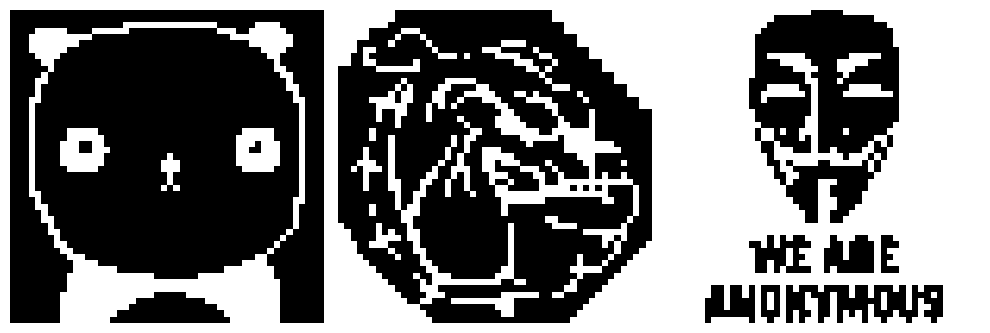

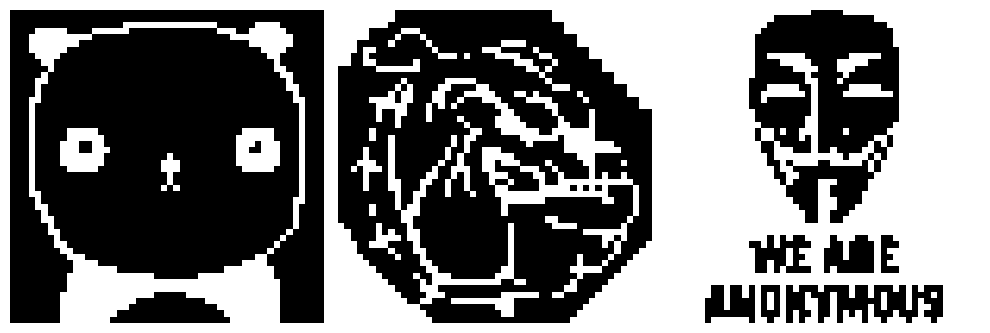

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [280]:
inverse_images_50x50 = generate_inverse_spurious_states(images_50x50)
plot_images(inverse_images_50x50)

predicted_50x50_inverse = HN_50x50.predict_multiple(inverse_images_50x50, (50, 50))
plot_images(predicted_50x50_inverse)

accuracies_50x50_inverse = calculate_accuracy(inverse_images_50x50, predicted_50x50_inverse)
for i, acc in enumerate(accuracies_50x50_inverse):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; A fin de continuar con el análisis, se repite el procedimiento con las imágenes de $60 \times 45$, generando sus correspondientes estados inversos y evaluando la capacidad de la red para reconstruirlos.

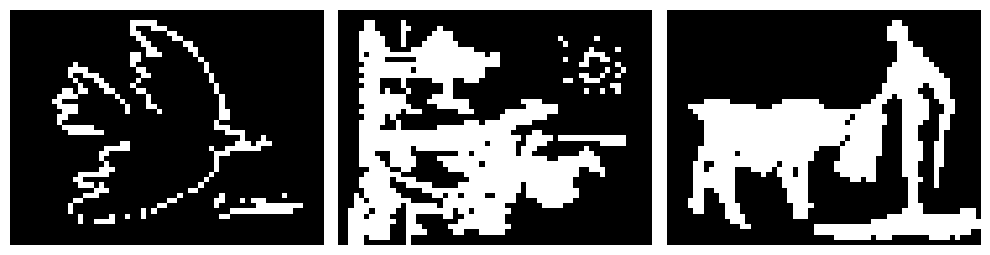

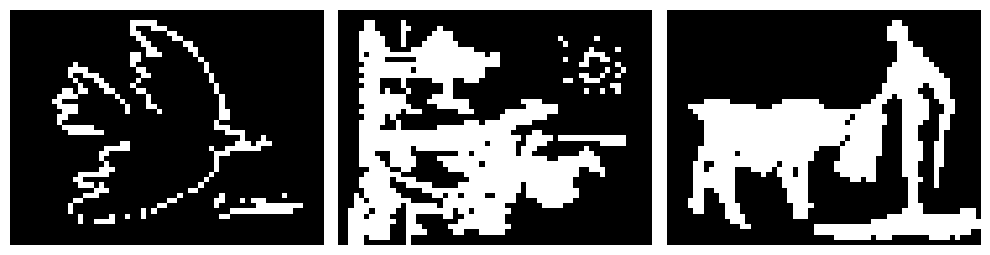

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [281]:
inverse_images_60x45 = generate_inverse_spurious_states(images_60x45)
plot_images(inverse_images_60x45)

predicted_60x45_inverse = HN_60x45.predict_multiple(inverse_images_60x45, (45, 60))
plot_images(predicted_60x45_inverse)

accuracies_60x45_inverse = calculate_accuracy(inverse_images_60x45, predicted_60x45_inverse)
for i, acc in enumerate(accuracies_60x45_inverse):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; Tanto en las imágenes de $50 \times 50$ como en las de $60 \times 45$, los resultados muestran que la red reconstruye los estados inversos con una accuracy del $100 \%$. Esto confirma que dichos patrones, aunque no forman parte del conjunto de entrenamiento, quedan almacenados como mínimos locales estables en la red. En otras palabras, la red de Hopfield no solo guarda los patrones originales, sino también sus inversos, lo cual constituye una manifestación clara de la presencia de este tipo de estados espurios en ambos tamaños de imagen.

&ensp; Por otro lado, se implementó la función $\texttt{combination\_spurious\_states}$, que genera estados espurios combinando un número impar de patrones mediante una regla de mayoría píxel a píxel. Para cada estado, se seleccionan aleatoriamente `n_comb` patrones (permitiendo invertir su signo) y se obtiene un patrón resultante que no pertenece al conjunto original, pero que la red puede almacenar como mínimo local. Además, se excluyen explícitamente los patrones originales y sus inversos para centrarse únicamente en espurios que son combinaciones lineales de los originales.

In [282]:
def combination_spurious_states(patterns, n_comb, n_states=3) -> list[np.ndarray]:
    """
    Generates n_states spurious states by combining n_comb random patterns (n_comb must be odd).
    Returns a list of combined patterns.
    """
    if patterns is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(patterns, list):
        raise ValueError("Input patterns must be a list")

    if n_comb % 2 == 0:
        raise ValueError("n_comb must be an odd number")

    n_patterns = len(patterns)
    hopfield_patterns = [np.where(2 * p - 1 >= 0, 1, -1) for p in patterns]
    hopfield_inverses = [-p for p in hopfield_patterns]

    spurious_states = []
    i = 0
    while i < n_states:
        replace = n_patterns < n_comb  # Allow replacement if not enough patterns
        index = np.random.choice(n_patterns, n_comb, replace=replace)
        idx_sign = np.random.choice([1, -1], n_comb)

        selected = [hopfield_patterns[j] * idx_sign[k] for k, j in enumerate(index)]
        combined = np.sum(selected, axis=0)
        combined = np.where(combined >= 0, 1, -1)

        if (not any(np.array_equal(combined, s) for s in spurious_states) 
            and not any(np.array_equal(combined, p) for p in hopfield_patterns)
            and not any(np.array_equal(combined, inv) for inv in hopfield_inverses)):
            spurious_states.append(combined)
            i += 1

    return spurious_states

&ensp; Para analizar el comportamiento de la red frente a este tipo de estados espurios, se generan imágenes a partir de la función presentada con antelidad con los patrones de $50 \times 50$. Estas se visualizan junto con las predicciones realizadas por la red entrenada, calculando finalmente la *accuracy* obtenida en cada caso.

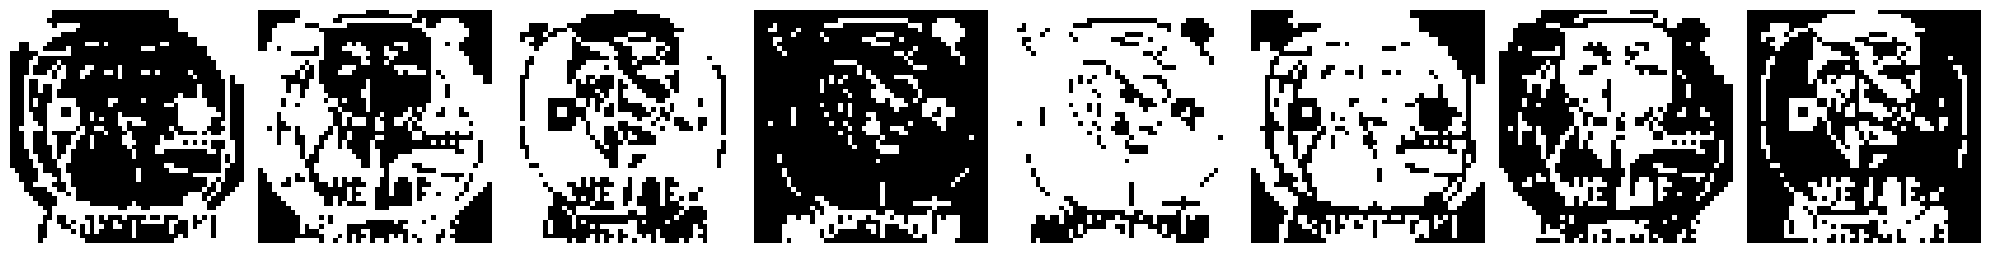

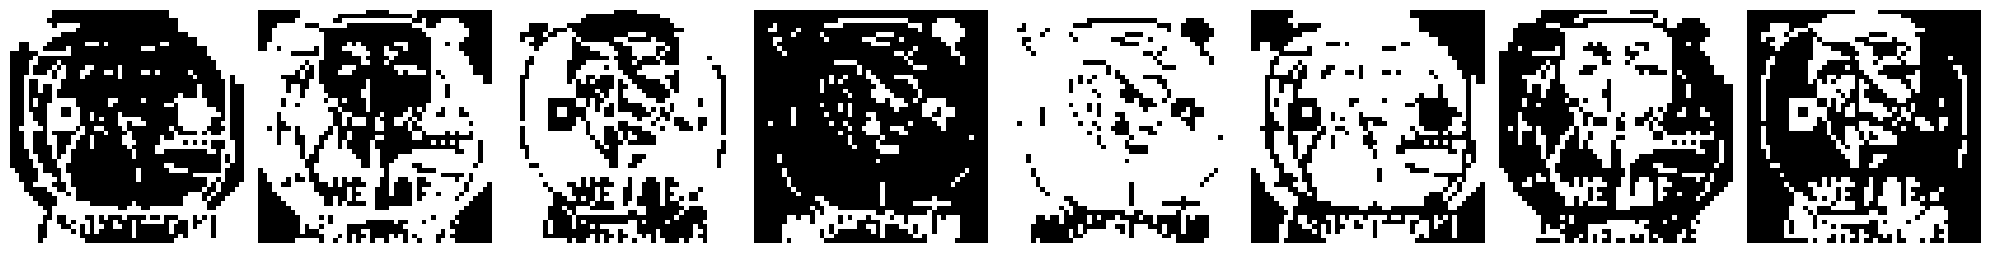

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [283]:
combinated_images_50x50 = combination_spurious_states(images_50x50, 3, 8)
plot_images(combinated_images_50x50)

predicted_50x50_combinated = HN_50x50.predict_multiple(combinated_images_50x50, (50, 50))
plot_images(predicted_50x50_combinated)

accuracies_50x50_combinated = calculate_accuracy(combinated_images_50x50, predicted_50x50_combinated)
for i, acc in enumerate(accuracies_50x50_combinated):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; De esta misma forma, se procede para la red entrenada previamente con los patrones de $60 \times 45$.

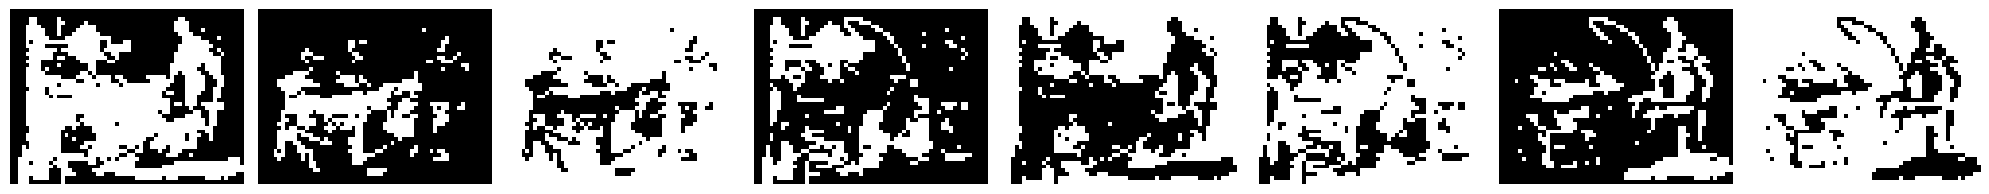

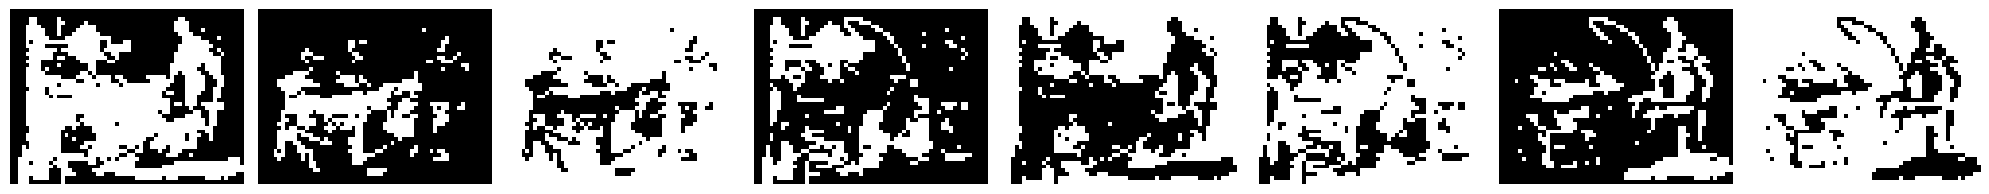

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [284]:
combinated_images_60x45 = combination_spurious_states(images_60x45, 3, 8)
plot_images(combinated_images_60x45)

predicted_60x45_combinated = HN_60x45.predict_multiple(combinated_images_60x45, (45, 60))
plot_images(predicted_60x45_combinated)

accuracies_60x45_combinated = calculate_accuracy(combinated_images_60x45, predicted_60x45_combinated)
for i, acc in enumerate(accuracies_60x45_combinated):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; Para concluir, en las imágenes de $50 \times 50$ y las de $60 \times 45$, los resultados muestran que la red logra reconstruir todos los patrones espurios generados por combinaciones lineales con una *accuracy* del $100\%$. Esto indica que dichas configuraciones, a pesar de no pertenecer al conjunto original de entrenamiento, son mínimos locales estables. En consecuencia, la red de Hopfield no solo almacena los patrones aprendidos y sus inversos, sino también combinaciones de ellos, lo que constituye una clara evidencia de la presencia de estados espurios en ambos tamaños de imagen.

&ensp;

**(D). Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.**

&ensp; En este apartado se busca analizar si la red de Hopfield es capaz de almacenar y aprender un mayor número de patrones. Para ello, se utilizan las $6$ imágenes disponibles, combinando las de $50 \times 50$ con las de $60 \times 45$ previamente redimensionadas a $50 \times 50$, de manera que todas tengan la misma dimensión. Una vez unificadas, se visualizan en conjunto para verificar los patrones a utilizar en el entrenamiento.

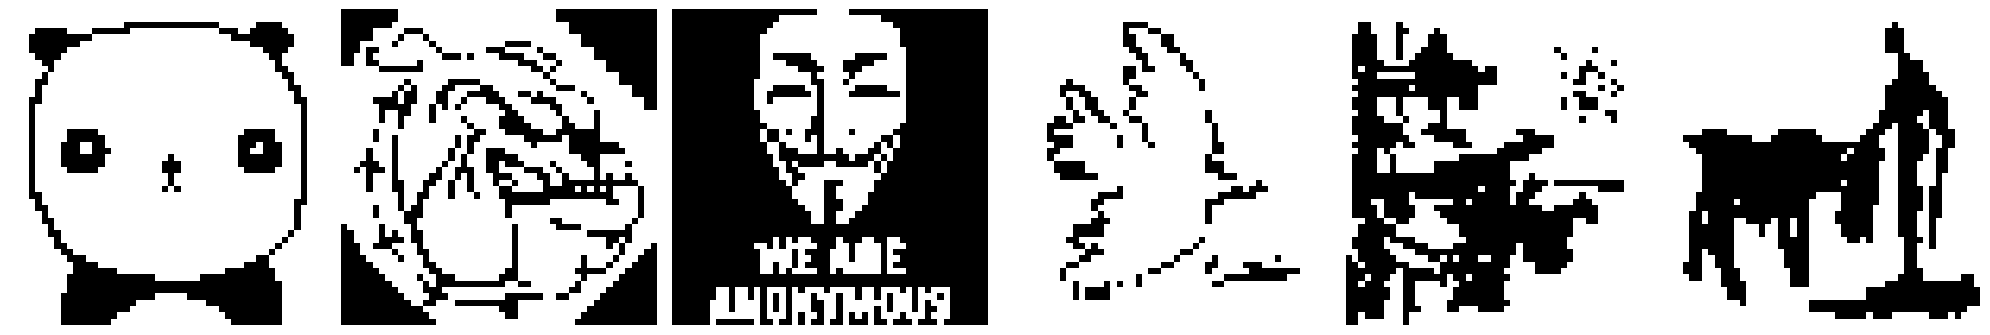

In [285]:
images_60x45_resized = load_images(path_60x45, resize=(50, 50))
all_images = images_50x50 + images_60x45_resized

plot_images(all_images)

&ensp; A continuación, se inicializa la red de Hopfield y se entrena con las seis imágenes unificadas. Luego, se obtienen las predicciones sobre ese mismo conjunto para evaluar la recuperación de los patrones almacenados. Las salidas se visualizan para una inspección cualitativa y, en paralelo, se calcula la *accuracy* individual de cada imagen.

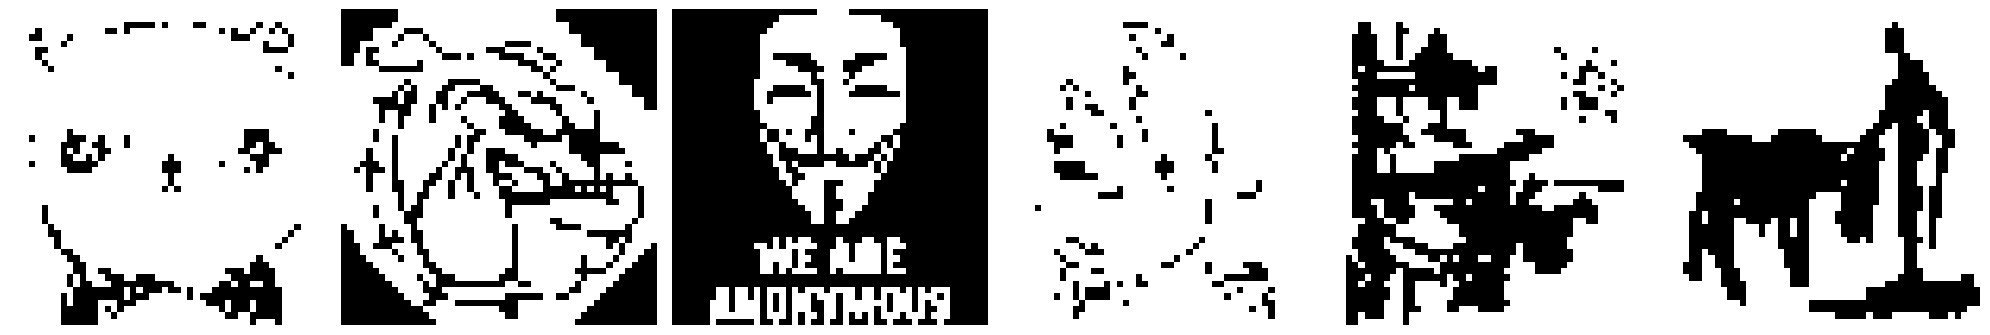

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [286]:
HN_all = HopfieldNetwork()
HN_all.train(all_images)
predicted_all = HN_all.predict_multiple(all_images, (50, 50))

plot_images(predicted_all)

accuracies_all = calculate_accuracy(all_images, predicted_all)
for i, acc in enumerate(accuracies_all):
    display(Latex(rf"$\text{{Imagen}} ~ {i+1}: \quad \textbf{{Accuracy}} = {acc:.0%}$%"))

&ensp; Al entrenar la red con las seis imágenes, se observa que la mayoría de los patrones son recuperados correctamente con una *accuracy* del $100\%$. Sin embargo, en los casos de las imágenes $1$ y $4$ la precisión cae al $91\%$ y $95\%$, respectivamente, lo que evidencia que la red no logra reconstruirlas de manera perfecta. Este comportamiento confirma que, a medida que aumenta el número de patrones almacenados, la red comienza a sufrir interferencias entre memorias y fenómenos de *crosstalk*, reduciendo su capacidad de recuperación exacta. En otras palabras, aunque la red aún conserva la mayor parte de la información, su límite de almacenamiento empieza a manifestarse.

&ensp; Con el fin de profundizar en esta limitación, se procede a calcular la correlación por definición entre cada par de patrones redimensionados a $50 \times 50$. Esta medida cuantifica el grado de similitud entre dos memorias: un valor cercano a $1$ indica patrones casi idénticos, mientras que valores próximos a $0$ reflejan baja correlación. De esta forma, se puede identificar qué imágenes presentan mayor solapamiento y, por lo tanto, son más propensas a interferir en la fase de recuperación.

In [287]:
def correlation(pattern1, pattern2):
    hopfield_pattern1 = np.where(2 * pattern1 - 1 >= 0, 1, -1)
    hopfield_pattern2 = np.where(2 * pattern2 - 1 >= 0, 1, -1)
    p1 = hopfield_pattern1.flatten()
    p2 = hopfield_pattern2.flatten()
    return np.mean(p1 * p2)

In [288]:
for i in range(len(all_images)):
    for j in range(i + 1, len(all_images)):
        corr = correlation(all_images[i], all_images[j])
        display(Latex(rf"$\text{{Correlation between pattern {i+1} and pattern {j+1}}}: {corr:.2f}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

&ensp; A partir de los resultados de correlación, se confirma que las imágenes $1$ y $4$ presentan los valores más altos entre sí, con una correlación de aproximadamente $0.51$, lo que indica un solapamiento significativo en sus patrones. Esto explica por qué justamente esas dos imágenes fueron las más difíciles de recuperar con exactitud durante el entrenamiento conjunto: la similitud entre ellas introduce interferencia en la dinámica de la red y genera que aumente el *crosstalk*. En contraste, las demás correlaciones se mantienen bajas o incluso negativas, lo que permite que los otros patrones se almacenen y recuperen sin inconvenientes.

---

<div style="text-align: left;">
  <h4><b>Ejercicio 2</b></h4>
</div>

**(A). Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).**

<center>

| $P_{\text{error}}$ | $\frac{p_{\text{max}}}{N}$ |
|--------|--------|
| 0,001  | 0,105  |
| 0,0036 | 0,138  |
| 0,01   | 0,185  |
| 0,05   | 0,37   |
| 0,1    | 0,61   |

</center>

<center>
<b>Tabla 1.</b> Valores de la carga crítica en función de la probabilidad de error.
</center>

&ensp; En este apartado se busca comprobar empíricamente la capacidad de almacenamiento de la red de Hopfield, entendida como el número máximo de patrones que pueden ser almacenados y recuperados sin error significativo en función del tamaño de la red. Los valores de referencia que se muestran en la *Tabla 2.1* corresponden a un análisis estadístico bajo actualización sincrónica y sirven como comparación para las simulaciones que se realizarán a continuación.  

&ensp; Para llevar a cabo esta validación, es necesario generar conjuntos de patrones binarios de prueba que puedan ser utilizados como memoria de la red. Siguiendo esta línea, se implementaron dos funciones auxiliares:  

- $\texttt{generate\_independent\_patterns}$: genera patrones completamente aleatorios e independientes entre sí.  
- $\texttt{generate\_correlated\_patterns}$: produce patrones que comparten cierta correlación controlada por un parámetro $\rho$, de manera que se derivan de un mismo patrón base con ciertas modificaciones aleatorias.  

&ensp; Estas funciones permiten evaluar el comportamiento de la red tanto en condiciones ideales (patrones independientes) como en escenarios más realistas donde existe correlación entre los patrones, y así analizar experimentalmente la relación entre capacidad y probabilidad de error.  

In [289]:
def generate_independent_patterns(n_original, pattern_shape) -> list[np.ndarray]:
    """
    Generates independent n_original random binary patterns of a given shape.
    """
    patterns = []
    i = 0
    while i < n_original:
        pattern = np.random.randint(0, 2, size=pattern_shape)
        if not any(np.array_equal(pattern, p) for p in patterns):
            patterns.append(pattern)
            i += 1
    return patterns

def generate_correlated_patterns(n_original, pattern_shape, rho) -> list[np.ndarray]:
    """
    Generates correlated n_original random binary patterns of a given shape.
    """
    q = (1.0 + np.sqrt(rho)) / 2.0
    p_flip = 1.0 - q 
    base_pattern = np.random.randint(0, 2, size=pattern_shape)
    
    patterns = []
    i = 0
    while i < n_original:
        mask = np.random.rand(*pattern_shape) < p_flip
        new_pattern = base_pattern.copy()
        new_pattern[mask] = 1 - new_pattern[mask]
        if not any(np.array_equal(new_pattern, p) for p in patterns):
            patterns.append(new_pattern)
            i += 1

    return patterns

&ensp; Una vez definida la función para generar patrones independientes, se construye un conjunto de $5$ patrones binarios de tamaño $30 \times 30$ y se los visualiza junto con el cálculo de la correlación entre cada par. Dado que los patrones se generan de forma completamente aleatoria, se espera que sus correlaciones sean cercanas a cero, confirmando así su independencia estadística. 


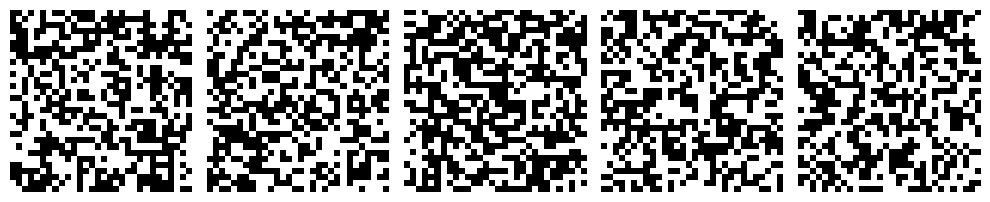

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [290]:
independent_patterns = generate_independent_patterns(5, (30, 30))
plot_images(independent_patterns)

for i in range(len(independent_patterns)-1):
     for j in range(i+1, len(independent_patterns)):
        corr_coef = correlation(independent_patterns[i], independent_patterns[j])
        display(Latex(rf"$\text{{Correlation between pattern {i+1} and pattern {j+1}}}: {corr_coef:.2f}$"))

&ensp; Para evaluar de manera experimental la capacidad de la red de Hopfield se implementaron funciones auxiliares que permiten cuantificar el error y estimar el número máximo de patrones que pueden almacenarse. En primer lugar, la función $\texttt{calculate\_error}$ compara los patrones originales con los recuperados por la red y devuelve el error medio de reconstrucción, definido como:

$$ \text{Error} = \frac{\# \, \text{bits distintos entre originales y predichos}}{\# \, \text{bits totales}} $$

&ensp; A continuación, la función $\texttt{get\_parameters}$ genera un conjunto de patrones independientes o correlacionados, los entrena en la red y determina el máximo número de patrones que pueden almacenarse sin superar una probabilidad de error dada. A partir de este valor se calcula la capacidad de la red con la expresión mostrada anteriormente:

$$ C= \frac{\# \, \text{máx patrones que no superan } p_{\text{error}}}{\# \, \text{neuronas}}  = \frac{p_{\text{max}}}{N} $$

&ensp; Por último, $\texttt{get\_multiple\_parameters}$ automatiza este procedimiento repitiéndolo para distintos valores de probabilidad de error, y en el caso de patrones correlacionados también para diferentes grados de correlación, devolviendo así la capacidad estimada en cada escenario.  


In [320]:
def calculate_error(original_patterns, predicted_patterns) -> float:
    """
    Calculates the error between the original and predicted patterns.
    """
    if original_patterns is None or predicted_patterns is None:
        raise ValueError("Input patterns cannot be None")

    if not isinstance(original_patterns, list) or not isinstance(predicted_patterns, list):
        raise ValueError("Input patterns must be lists")

    n_original = len(original_patterns)
    if n_original != len(predicted_patterns):
        raise ValueError("Original and predicted patterns must have the same length")

    original = [np.where(2 * original_patterns[i] - 1 >= 0, 1, -1) for i in range(n_original)] # Convert to -1 & 1
    mean_errors = []
    for i in range(n_original):
        if original[i].shape != predicted_patterns[i].shape:
            raise ValueError("All patterns must have the same shape")

        mean_errors.append(np.mean(original[i] != predicted_patterns[i]))

    return np.mean(mean_errors)

def get_parameters(n_patterns, size, proba_error, independence, rho, remove_rate) -> tuple[float, int]:
    """
    Generates patterns (independent or correlated) and calculates the capacity and maximum patterns
    """
    if proba_error is None:
        raise ValueError("proba_error cannot be None")

    if n_patterns is None:
        raise ValueError("n_patterns cannot be None")

    max_patterns = 0
    for n in n_patterns:
        patterns = (generate_independent_patterns(n, size) if independence else generate_correlated_patterns(n, size, rho))
        
        HN = HopfieldNetwork()
        HN.train(patterns, remove_rate)
        predicted = HN.predict_multiple(patterns, size, synchronic=True)
        
        error = calculate_error(patterns, predicted)
        if error > proba_error:
            break
        else:
            max_patterns = n

    return (max_patterns / np.prod(size), max_patterns)

def get_multiple_parameters(size, probas_error, independence=True, rhos=None, remove_rate=None) -> list[tuple[float, int]]:
    """
    Generates patterns (independent or correlated) and calculates the capacity and maximum patterns for
    each error probability or correlation strength.
    """
    if probas_error is None:
        raise ValueError("probas_error cannot be None")

    if not isinstance(probas_error, list):
        raise ValueError("probas_error must be a list")

    results = []
    
    if independence:
        previous_max_pattern = 1
        for proba in probas_error:
            n_patterns = np.linspace(previous_max_pattern, previous_max_pattern + 200, 50, dtype=int)
            aux = get_parameters(n_patterns, size, proba, independence=True, rho=None, remove_rate=remove_rate)
            results.append(aux)
            previous_max_pattern = aux[1]

    else:
        for rho in rhos:
            for proba in probas_error:
                n_patterns = np.linspace(1, 150, 50, dtype=int)
                aux = get_parameters(n_patterns, size, proba, independence, rho, remove_rate)
                results.append(aux)

    return results

&ensp; Con el fin de contrastar los resultados experimentales con los valores teóricos de la *Tabla 2.1*, se analiza la capacidad de la red para distintos tamaños de patrones: $10 \times 10$, $20 \times 20$, $30 \times 30$ y $40 \times 40$. En cada caso, se calcula el número máximo de patrones que la red puede almacenar sin superar las probabilidades de error establecidas en la tabla. A partir de estos valores se determina la capacidad $C = \frac{p_{\text{max}}}{N}$ y el número de patrones almacenados, lo que permite examinar cómo varía el rendimiento de la red en función tanto de la cantidad de neuronas como del nivel de error tolerado.  

In [293]:
sizes = [(10, 10), (20, 20), (30, 30), (40, 40)]
probas_error = [0.001, 0.0036, 0.01, 0.05, 0.1]
results = []

for size in sizes:
    display(Latex(rf"$------ \textbf{{Tamaño de la red}}: {size[0]} \times {size[1]} ------$"))
    aux = get_multiple_parameters(size, probas_error)
    results.append(aux)

    for i, (capacity, max_patterns) in enumerate(aux):
        display(Latex(rf"$p_{{\text{{error}}}} = {probas_error[i]} \quad \Longrightarrow \quad C \approx {capacity:.2f}, ~~ \textbf{{Max Patterns}} = {max_patterns}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

&ensp; Así, habiendo obtenido los valores de capacidad práctica para cada tamaño de red y nivel de error, resulta conveniente compararlos con las capacidades teóricas de la *Tabla 2.1*. Para ello, se define la función $\texttt{plot\_capacities}$, que representa en un mismo gráfico las capacidades teóricas y experimentales en función de la probabilidad de error. De esta manera, se visualiza de forma clara cómo varía el desempeño real de la red respecto a lo esperado en teoría para distintos tamaños de patrones.

In [294]:
def plot_capacities(theory, practical, probas, size, iteration) -> None:
    """
    Plots the theoretical and practical capacities of the Hopfield network against error probabilities.
    """
    if theory is None or practical is None or probas is None:
        raise ValueError("Theoretical and practical capacities cannot be None")

    if not isinstance(theory, list) or not isinstance(practical, list) or not isinstance(probas, list):
        raise ValueError("Capacities must be lists")

    if len(theory) != len(practical) or len(theory) != len(probas):
        raise ValueError("Theory, practical, and probas lists must have the same length")

    x = np.arange(len(probas))  
    width = 0.35 

    if iteration == 1:
        plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, iteration)
    plt.bar(x - width/2, theory, width, label='Theoretical', edgecolor='k', zorder=3)
    plt.bar(x + width/2, practical, width, label='Practical', edgecolor='k', zorder=3)

    plt.title(f'Hopfield Network Capacities (N = {size[0]} x {size[1]})')
    plt.xlabel('Error Probability')
    plt.ylabel('Capacity')
    plt.xticks(x, probas)
    plt.grid(zorder=0)
    plt.legend()

    if iteration == 4:
        plt.tight_layout()
        plt.show()

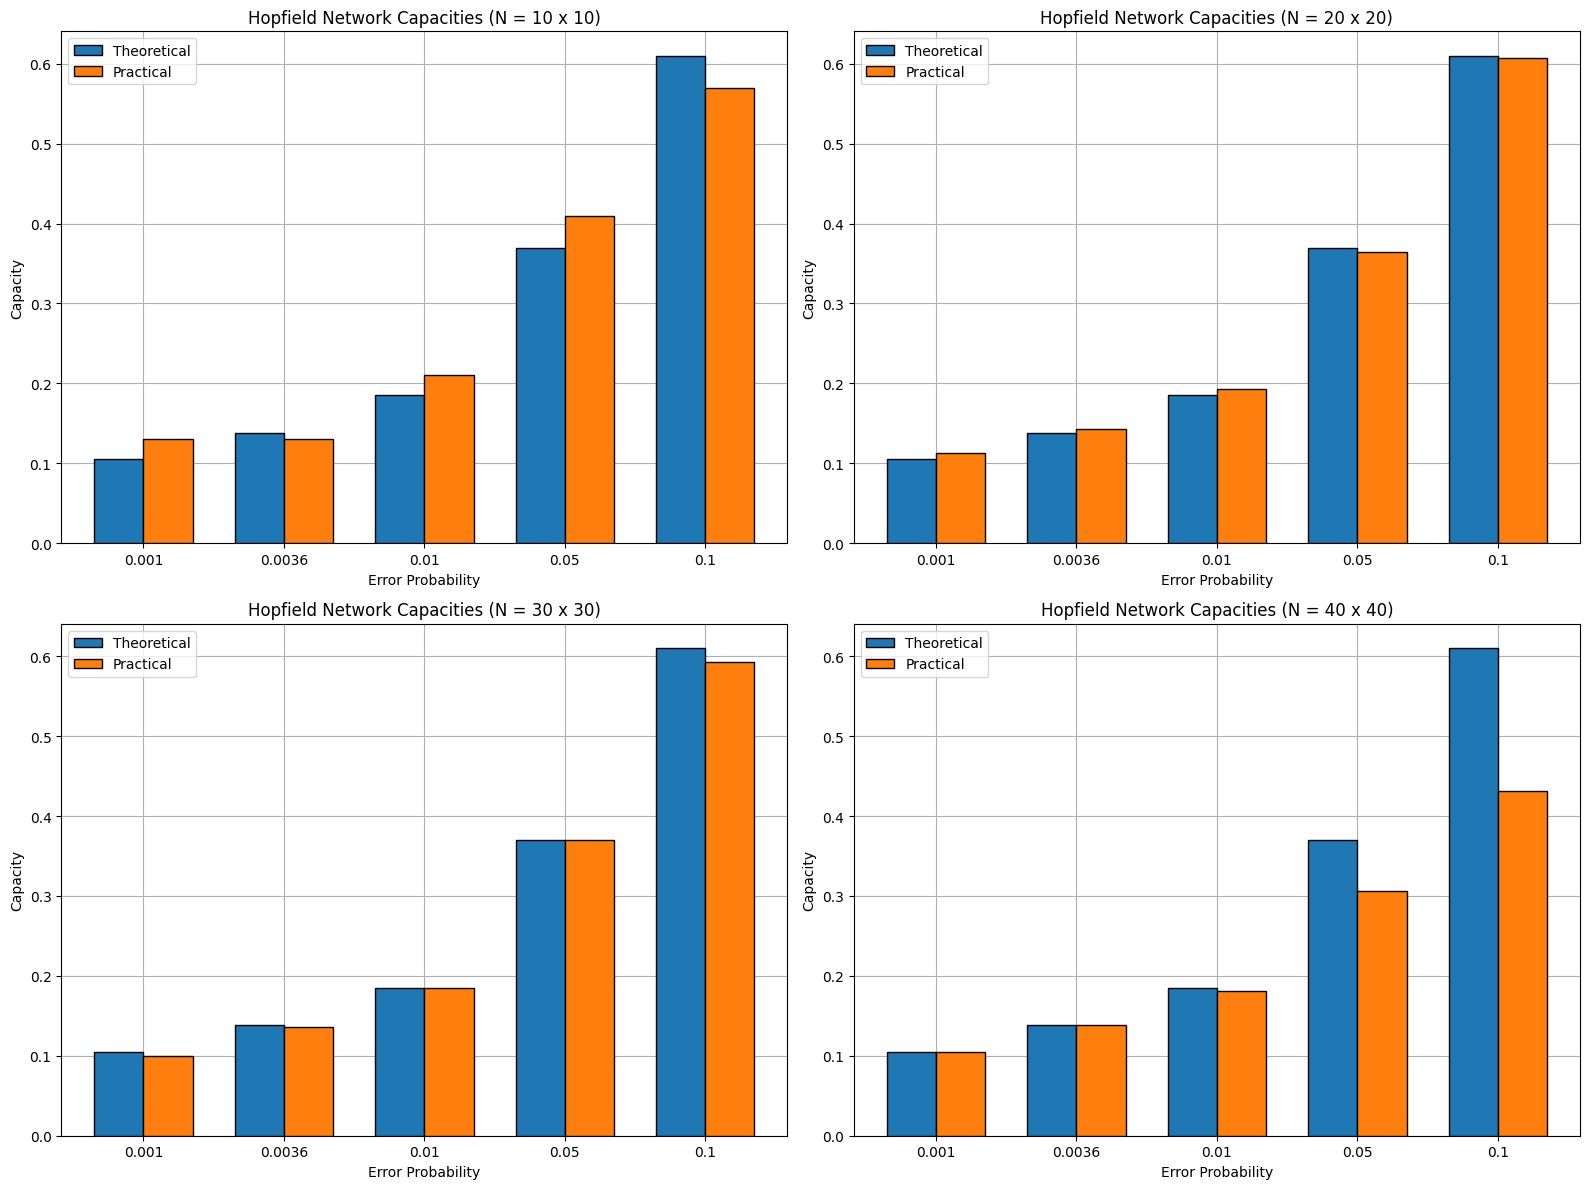

In [295]:
theo_capacity = [0.105, 0.138, 0.185, 0.37, 0.61]
for i, size in enumerate(sizes):
    practical_capacity = [r[0] for r in results[i]]
    plot_capacities(theo_capacity, practical_capacity, probas_error, size, i+1)

&ensp; En base a los gráficos comparativos se observa una buena concordancia entre las capacidades teóricas y las obtenidas experimentalmente para tamaños de red pequeños y medianos ($10 \times 10$, $20 \times 20$ y $30 \times 30$). En estos casos, la capacidad estimada mediante simulaciones sigue de cerca los valores predichos por la teoría, mostrando que el modelo de Hopfield reproduce adecuadamente el comportamiento esperado.  

&ensp; Sin embargo, al aumentar el tamaño de la red a $40 \times 40$, es decir, $N = 1600$ neuronas, comienza a notarse una discrepancia más evidente. Las capacidades prácticas resultan sistemáticamente menores que las teóricas, especialmente para niveles altos de tolerancia al error, como $p_{\text{error}} = 0.05$ y $0.1$. Esto indica que, a medida que crece el número de neuronas, las simulaciones sufren más interferencias y fenómenos de *crosstalk*, lo cual limita la capacidad de la red respecto al ideal teórico. En otras palabras, si bien la teoría proporciona una buena aproximación, en la práctica la red muestra restricciones adicionales que se hacen más evidentes con tamaños grandes.  

&ensp; En conclusión, los resultados obtenidos muestran que la capacidad de almacenamiento de la red de Hopfield coincide en gran medida con las predicciones teóricas presentadas en la Tabla 2.1, especialmente para redes de tamaño reducido y medio. Esto valida la formulación estadística que establece el límite de patrones que pueden ser almacenados sin degradar significativamente el rendimiento. No obstante, a medida que el tamaño de la red crece, como en el caso de $40 \times 40$, la discrepancia entre teoría y práctica se hace más notoria debido a la aparición de fenómenos como el *crosstalk* y la acumulación de correlaciones espurias, que afectan la estabilidad de los mínimos locales. De esta manera, se evidencia que la teoría describe el comportamiento asintótico de manera general, pero las simulaciones ponen de manifiesto limitaciones prácticas adicionales que restringen la capacidad de la red.  

&ensp;

**(B). Proponer una manera de generar patrones con distintos grados de correlación. Utilice el método propuesto para analizar cómo varía la capacidad de la red de Hopfield en función de la correlación entre patrones.**

&ensp; Para este punto se implementó la función $\texttt{generate\_correlated\_patterns}$, presentada en el inciso anterior. Su objetivo es construir patrones binarios con un grado de correlación controlado. La idea es partir de un **patrón base** generado aleatoriamente y, a partir de él, obtener nuevas configuraciones aplicando inversiones de bits de forma probabilística.  

&ensp; En particular, para cada píxel del patrón base se define la probabilidad $q$ de mantenerse igual y la probabilidad complementaria de invertirse $p_{\text{flip}}$, ambas determinadas a partir del parámetro de correlación $\rho$:  

$$
q = \frac{1 + \sqrt{\rho}}{2}, \qquad  p_{\text{flip}} = \frac{1 - \sqrt{\rho}}{2}.
$$

&ensp; Representando los patrones en $\{-1, 1\}$, cada patrón generado $P_{\text{new}}$ puede escribirse como el producto entre el patrón base $P_{\text{base}}$ y una máscara aleatoria $M$, que se modela como una variable aleatoria de tipo bernoulli con parámetro $q$.

$$
M = 
\begin{cases}
+1, & \text{con probabilidad } q. \\
-1, & \text{con probabilidad } p_{\text{flip}}.
\end{cases} \sim \text{Ber}(q)
$$

Así, al querer calcular la correlación entre dos patrones como $P_{\text{new}}^1 = P_{\text{base}} \cdot M_1$ y $P_{\text{new}}^2 = P_{\text{base}} \cdot M_2$, se tiene que:  

$$
\mathbb{E}[P_{\text{new}}^1 \cdot P_{\text{new}}^2] = \mathbb{E}[P_{\text{base}}^2 \cdot M_1 \cdot M_2] = \mathbb{E}[M_1 \cdot M_2] = \big(\mathbb{E}[M]\big)^2.
$$

&ensp; De esta manera, como $M$ se comporta como una variable Bernoulli en $\{-1, 1\}$, su esperanza es conocida, dando así el siguiente resultado para la correlación entre patrones:  

$$
\mathbb{E}[M] = (+1)\cdot q + (-1)\cdot p_{\text{flip}} = q - p_{\text{flip}} = \sqrt{\rho} \Longrightarrow \mathbb{E}[P_{\text{new}}^1 \cdot P_{\text{new}}^2] = (\sqrt{\rho})^2 = \rho
$$

&ensp; En conclusión, al definir $q$ y $p_{\text{flip}}$ según estas expresiones, la función garantiza que el conjunto de patrones generados presente un grado de correlación promedio igual a $\rho$. Siguiendo con la teoría desarrollada, se generan $5$ patrones correlacionados con un parámetro $\rho = 0.35$ a partir de la función $\texttt{generate\_correlated\_patterns}.$ A partir de esto, se calcula la correlación y se espera que el resultado obtenido entre patrones sea congruente con el parámetro $\rho$.


In [ ]:
correlated_patterns = generate_correlated_patterns(5, (30, 30), 0.35)
plot_images(correlated_patterns)

for i in range(len(correlated_patterns)-1):
    for j in range(i+1, len(correlated_patterns)):
        corr = correlation(correlated_patterns[i], correlated_patterns[j])
        display(Latex(rf"$\text{{Correlation between pattern {i+1} and pattern {j+1}}}: {corr:.2f}$"))

&ensp; A continuación, se define la función $\texttt{plot\_capacities\_vs\_correlation}$, que permite representar la capacidad de la red en función del grado de correlación $\rho$ entre patrones. De este modo, se espera oobservar de forma cualitativa cómo, a medida que aumenta la similitud entre los patrones almacenados, la capacidad práctica de la red disminuye respecto del caso independiente, pudiendo comparar este efecto para distintos tamaños de red y con la referencia teórica.  

In [296]:
def plot_capacities_vs_correlation(sizes, rhos, proba, theoretical, iteration) -> None:
    """
    Plots the capacities of the Hopfield network against correlation strengths.
    """
    if rhos is None or proba is None:
        raise ValueError("Rhos and probabilities cannot be None")

    if not isinstance(rhos, list):
        raise ValueError("Rhos must be a list")
    
    if iteration == 1:
        plt.figure(figsize=(16, 6))
    
    for size in sizes:
        corr_results = get_multiple_parameters(size, [proba], independence=False, rhos=rhos)
        corr_capacities = [r[0] for r in corr_results]
        plt.subplot(1, 2, iteration)
        plt.plot(rhos, corr_capacities, marker='o', linestyle='-', label=f'$N={size[0]}x{size[1]}$', zorder=3)
    
    plt.axhline(y=theoretical, color='k', linestyle='--', alpha=0.5, label='Theoretical', zorder=3)

    plt.title(rf'Hopfield Network Capacities vs Correlation Strength (p={proba})')
    plt.xlabel('Correlation Strength')
    plt.ylabel('Capacity')
    plt.grid(zorder=0)
    plt.legend()

    if iteration == 2:
        plt.tight_layout()
        plt.show()

&ensp; En base a esta función, se grafica la capacidad en función de la autocorrelación entre patrones para las probabilidades de error de $0.001$ y $0.0036$.

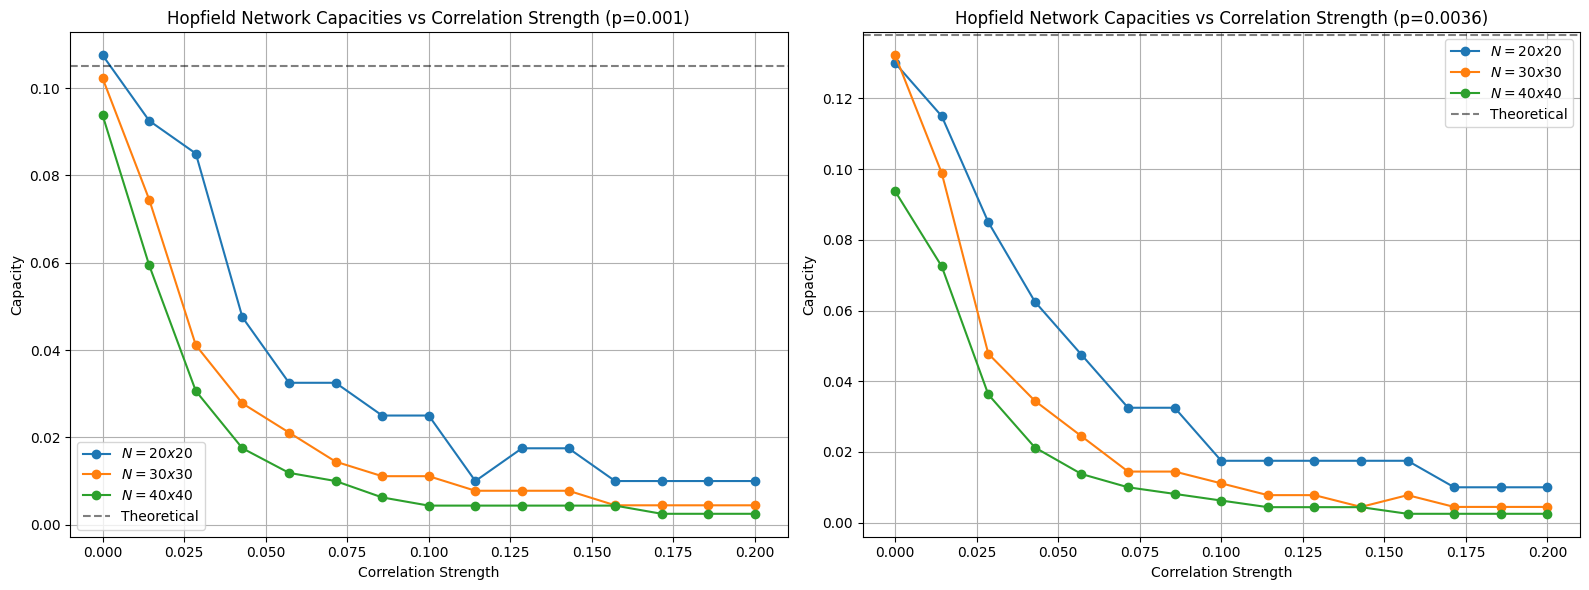

In [297]:
rhos_correlate = np.linspace(0, 0.2, 15)

for i in range(2):
    plot_capacities_vs_correlation(sizes[1::], list(rhos_correlate), probas_error[i], theo_capacity[i], i+1)

&ensp; Los resultados muestran con claridad cómo la correlación entre patrones afecta la capacidad de la red de Hopfield. En el caso independiente $\rho \to 0$, la capacidad práctica se ajusta bastante bien a lo esperado en teoría, lo que confirma el correcto funcionamiento del modelo. Sin embargo, tal como ya se había observado previamente, en el caso de redes de mayor tamaño como $40 \times 40$, la capacidad práctica se desvía más de la teórica. Esto se debe a que un número tan elevado de neuronas introduce mayores exigencias y hace que las simulaciones no resulten tan precisas como en tamaños más pequeños.  

&ensp; Cuando la correlación entre patrones empieza a aumentar, la capacidad cae rápidamente. Esto ocurre porque los patrones dejan de ser realmente distintos entre sí y comienzan a confundirse dentro de la red, lo que provoca un incremento del *crosstalk* y una recuperación menos confiable. En consecuencia, incluso con valores moderados de $\rho$, la capacidad tiende a valores cercanos a cero. En todos los tamaños de red evaluados se repite esta misma tendencia: se parte de un valor cercano al caso independiente y, a medida que los patrones se correlacionan, la capacidad se desploma, resaltando la importancia de la independencia estadística para mantener un buen almacenamiento en la red.  

---

<div style="text-align: left;">
  <h4><b>Ejercicio 3</b></h4>
</div>

**Implemente una red de Hopfield ´82 que aprenda patrones pseudo-aleatorios y estudie qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar.**

**(A). ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?**


&ensp; En este apartado se busca analizar la robustez de la red de Hopfield frente a la eliminación aleatoria de conexiones sinápticas. Para abordar este problema particularmente en cómo cambia el error de la red, se define la función $\texttt{get\_error\_vs\_removal\_rate}$, que calcula el error promedio de la red para diferentes tasas de eliminación. El procedimiento consiste en generar un conjunto de patrones independientes, entrenar la red con una tasa de eliminación de conexiones específica y evaluar luego la recuperación de los patrones originales. El error se obtiene como la fracción de bits incorrectamente reconstruidos, de manera análoga a lo trabajado en secciones anteriores.  

&ensp; Por otro lado, la función $\texttt{plot\_error\_vs\_removal\_rate}$ permite visualizar de forma clara los resultados obtenidos. A través de un gráfico, se representa cómo evoluciona el error en función del porcentaje de conexiones eliminadas, lo que facilita comparar el efecto de distintos valores de la cantidad de patrones almacenados.

In [298]:
def get_error_vs_removal_rate(removal_rates, size, synchronic, n_patterns) -> list[float]:
    """
    Calculates the error of the model trained with n_patterns for different removal rates of interconnections.
    """
    if removal_rates is None:
        raise ValueError("Removal rates cannot be None")

    errors = []
    for rate in removal_rates:
        patterns = generate_independent_patterns(n_patterns, size)
        HN = HopfieldNetwork()
        HN.train(patterns, remove_rate=rate)
        predicted = HN.predict_multiple(patterns, size, synchronic)
        error = calculate_error(patterns, predicted)
        errors.append(error)

    return errors

def plot_error_vs_removal_rate(removal_rates, errors, iteration, n_patterns) -> None:
    """
    Plots the error of the model against removal rates of interconnections.
    """
    if removal_rates is None or errors is None:
        raise ValueError("Removal rates and errors cannot be None")

    if len(removal_rates) != len(errors):
        raise ValueError("Removal rates and errors lists must have the same length")

    if iteration == 1:
        plt.figure(figsize=(8, 6))
    
    plt.plot(removal_rates * 100, errors, zorder=3, label=f'N={n_patterns}')

    plt.title(f'Error vs Removal Rate')
    plt.xlabel('Removal Rate (%)')
    plt.ylabel('Error')
    plt.grid(zorder=0)
    plt.tight_layout()

    if iteration == 11:
        plt.legend()
        plt.show()

&ensp; Así, se grafica el error en función del porcentaje de sinapsis eliminadas de la matriz de pesos $w_{ij}$ a la hora de entrenar a la red de Hopfield.

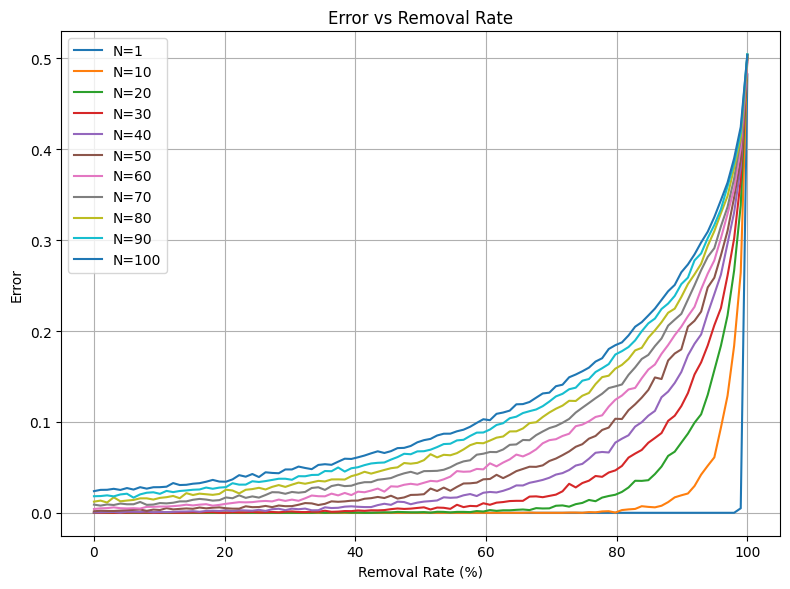

In [308]:
remove_rates = np.linspace(0, 1, 100)
n_patterns = np.arange(0, 101, 10)
n_patterns[0] = 1  

for i, n in enumerate(n_patterns):
    errors = get_error_vs_removal_rate(remove_rates, (20, 20), synchronic=True, n_patterns=n)
    plot_error_vs_removal_rate(remove_rates, errors, iteration=i+1, n_patterns=n)

&ensp; Los resultados obtenidos muestran que, para valores bajos de eliminación de sinapsis, la red de Hopfield mantiene un error reducido, lo que indica una notable robustez frente a fallos parciales en las conexiones. Sin embargo, a medida que se aumenta el porcentaje de conexiones eliminadas, el error empieza a crecer de forma exponencial hasta llegar a valores cercanos a $0.5$, lo que indica que no es capaz de recuperar los patrones correctamente.  

&ensp; Además, se evidencia que la cantidad de patrones almacenados $N$ influye significativamente, ya que, para $N$ pequeños, la red tolera mejor la pérdida de sinapsis, manteniendo errores bajos con tasas medias de eliminaciones. En cambio, cuando $N$ es elevado, la memoria está más cargada y el error crece más rápido, indicando que cuando la red está exigida se vuelve más sensible a la pérdida de sinapsis.  

&ensp; En resumen, las simulaciones muestran que la red de Hopfield posee una tolerancia limitada pero no despreciable a la pérdida de conexiones. Este comportamiento reproduce lo esperado: mientras exista redundancia en las conexiones, la memoria se preserva correctamente, pero al eliminar un porcentaje alto de sinapsis el rendimiento se degrada rápidamente.  

&ensp;


**(B). ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?**

&ensp; Al igual que en el inciso anterior, se busca comprobar el comportamiento de un parámetro de la red frente a eliminaciones de interconexiones. En este caso, el objetivo no es medir el error directamente, sino analizar cómo varía la capacidad de almacenamiento efectiva $C = \frac{p_{\text{max}}}{N}$ a medida que se incrementa el porcentaje de sinapsis eliminadas.  

&ensp; Para ello, se define la función $\texttt{plot\_capacity\_vs\_removal\_rate}$, que representa gráficamente la capacidad práctica de la red frente al porcentaje de conexiones eliminadas. Además, se incluye una línea de referencia con la capacidad teórica para poder comparar de forma visual cómo se degrada el rendimiento de la red en relación con lo esperado idealmente.


In [347]:
def plot_capacity_vs_removal_rate(removal_rates, capacities, theoretical_capacity, proba_error, iteration) -> None:
    """
    Plots the capacity of the model against removal rates of interconnections.
    """
    if removal_rates is None or capacities is None:
        raise ValueError("Removal rates and capacities cannot be None")

    if len(removal_rates) != len(capacities):
        raise ValueError("Removal rates and capacities lists must have the same length")

    if iteration == 1:
        plt.figure(figsize=(8, 6))

    colors = ['#1f77b4',  '#ff7f0e',  '#2ca02c']
    plt.plot(removal_rates * 100, capacities, zorder=3, color=colors[iteration-1], marker='o', linestyle='-', label=f'P={proba_error}')
    plt.axhline(y=theoretical_capacity, color=colors[iteration-1], linestyle='--', alpha=0.5, label=f'Theoretical ({theoretical_capacity})', zorder=3)

    plt.title(f'Capacity vs Removal Rate')
    plt.xlabel('Removal Rate (%)')
    plt.ylabel('Capacity')
    plt.grid(zorder=0)
    plt.tight_layout()

    if iteration == 3:
        plt.legend()
        plt.show()

&ensp; Entonces, para analizar cómo varía la capacidad de la red en función de la eliminación de sinapsis, se considera un rango de tasas de borradode interconexiones entre $0$ y $100\%$. En cada caso se estima la capacidad práctica de la red con patrones independientes de tamaño $30 \times 30$, evaluando distintos niveles de probabilidad de error $p_{\text{error}} = 0.001,~0.0036,~0.01$. Luego, mediante la función $\texttt{plot\_capacity\_vs\_removal\_rate}$, se grafican los resultados obtenidos junto con las capacidades teóricas de referencia, lo que permite observar de manera comparativa el impacto de la pérdida de conexiones sobre el almacenamiento de la red.  


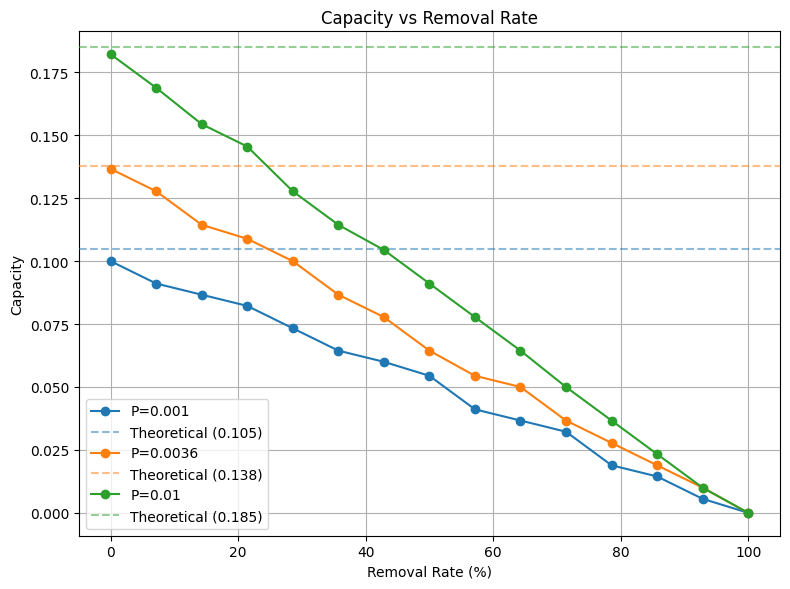

In [349]:
remove_rates = np.linspace(0, 1, 15)
partial_probas_error = [0.001, 0.0036, 0.01]
theo_proba_capacity = [0.105, 0.138, 0.185]

for idx, proba in enumerate(partial_probas_error):
    results = []
    for rate in remove_rates:
        aux = get_multiple_parameters((30, 30), [proba], independence=True, rhos=None, remove_rate=rate)
        results.append(aux)
        
    capacities = [c[0][0] for c in results]
    plot_capacity_vs_removal_rate(remove_rates, capacities, theo_proba_capacity[idx], proba, idx+1)

&ensp; En base a los resultados obtenidos se observa un comportamiento claro, la capacidad de la red disminuye progresivamente a medida que aumenta el porcentaje de sinapsis eliminadas. Para tasas de eliminación bajas, la red logra mantener una capacidad próxima a la teórica, mostrando cierta tolerancia a la pérdida parcial de conexiones. Sin embargo, conforme la eliminación se incrementa, la capacidad cae de manera lineal hasta alcanzar valores nulos cuando la red queda completamente desconectada.  

&ensp; Además, se aprecia que este comportamiento es consistente para las distintas probabilidades de error consideradas: todas las curvas parten cerca de su valor teórico correspondiente y convergen a cero cuando la tasa de eliminación es del $100\%$. Esto confirma que la eliminación de sinapsis afecta directamente la capacidad de almacenamiento de la red, limitando su funcionamiento aun cuando el número de patrones almacenados se mantenga constante.  


---
---

<div style="text-align: left;">
  <h3><b>Conclusiones</b></h3>
</div>

&ensp;  A lo largo del trabajo se exploraron distintos aspectos de las redes de Hopfield, tanto desde su formulación teórica como a través de simulaciones computacionales. De esta forma, se logró obtener una visión integral de su funcionamiento, reconociendo a la vez su funcionalidad como modelo de memoria asociativa y las limitaciones prácticas que presenta.

&ensp; Los resultados obtenidos confirman que la red de Hopfield es capaz de recuperar patrones con notable eficacia siempre que las distorsiones sean moderadas. Cuando el nivel de ruido o borrado se mantiene por debajo de un umbral, la red reconstruye los patrones casi perfectamente; sin embargo, al superarlo, la precisión cae abruptamente, evidenciando su sensibilidad y el límite práctico de tolerancia.

&ensp; En cuanto a los estados espurios, se comprobó que la red no solo almacena los patrones de entrenamiento, sino también sus inversos y ciertas combinaciones de un número impar de memorias. Esto reproduce lo planteado en el marco teórico y demuestra que la red se puede estabilizar en mínimos locales o configuraciones no deseadas, lo que representa una limitación en su capacidad de almacenamiento fiel.

&ensp; Respecto de la capacidad, se observó una buena correspondencia entre los resultados teóricos y experimentales en redes pequeñas y medianas. Sin embargo, al aumentar el tamaño de la red (por ejemplo, a $1600$ neuronas), las simulaciones comenzaron a desviarse de lo esperado, reflejando tanto limitaciones del modelo como del enfoque computacional. Además, se confirmó que la capacidad disminuye drásticamente cuando los patrones presentan correlación, incluso en niveles moderados, lo que pone en evidencia la importancia de la independencia estadística en el desempeño de la red.

&ensp; Finalmente, al analizar la eliminación de interconexiones, se vio que la red mantiene un rendimiento aceptable cuando la pérdida es reducida, gracias a la redundancia de sus conexiones. No obstante, cuando la proporción de sinapsis eliminadas es elevada, el error aumenta de manera significativa y la red pierde su capacidad de recuperación.

&ensp; En conjunto, el trabajo permitió caracterizar de manera integral el comportamiento de la red de Hopfield. Si bien se confirma que es útil como modelo de memoria asociativa, también quedan claras sus limitaciones frente a aspectos no considerados en la idealidad de la teoría, tales como: la sensibilidad al ruido elevado, la aparición de estados espurios, la capacidad restringida, la vulnerabilidad a correlaciones y los fallos estructurales. Estos aspectos marcan el alcance práctico de este modelo dentro de las redes neuronales.